In [1]:
# Importing required packages
# Importing sqlalchemy as snowflake connector


import pandas as pd
import numpy as np
import os

from dateutil import parser
import datetime

import pandas_profiling as pp

import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator
import seaborn as sns
sns.set()

from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
# helper function to establish snowflake credentials
# NOTE to reader: assumes you are using environment vars
    # SNOWFLAKE_USERNAME = USERNAME
    # SNOWFLAKE_PASSWORD = PASSWORD

from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import logging
import os

def cmic_connection(schema='DBT'):
    """
    Establish connection to Snowflake DB using SQLAlchemy
    """
    user = dict(os.environ)['SNOWFLAKE_USERNAME']
    password = dict(os.environ)['SNOWFLAKE_PASSWORD']
    
    # turn off Snowflake logging
    # https://stackoverflow.com/questions/56525319/turning-off-snowflake-db-logging-while-still-keeping-log-level-as-debug
    for name in logging.Logger.manager.loggerDict.keys():
        if 'snowflake' in name:
            logging.getLogger(name).setLevel(logging.WARNING)
            logging.getLogger(name).propagate = False

    
    engine = create_engine(URL(
    account = 'yk42692.us-east-1',
    user = user,
    password = password,
    database = 'CMIC_HISTORICAL',
    schema = schema,
    warehouse = 'DS_DL_WH_01',
    role='READ_WRITE_USER_CMIC_HISTORICAL',
    ))

    return engine


def pxl_connection(schema='RAW_DATA'):
    """
    Establish connection to Snowflake DB using SQLAlchemy

    Requires a local config.py file with user='USER_NAME' 
    and password='PASSWORD'
    """
    user = dict(os.environ)['SNOWFLAKE_USERNAME']
    password = dict(os.environ)['SNOWFLAKE_PASSWORD']
    
    # turn off Snowflake logging
    # https://stackoverflow.com/questions/56525319/turning-off-snowflake-db-logging-while-still-keeping-log-level-as-debug
    for name in logging.Logger.manager.loggerDict.keys():
        if 'snowflake' in name:
            logging.getLogger(name).setLevel(logging.WARNING)
            logging.getLogger(name).propagate = False

    
    engine = create_engine(URL(
    account = 'yk42692.us-east-1',
    user = user,
    password = password,
    database = 'PAREXEL_DEV',
    schema = schema,
    warehouse = 'DS_DL_WH_01',
    role='DATA_SCIENCE',
    ))

    return engine

In [3]:
cmic = cmic_connection()
pxl  = pxl_connection()

# create excel sheet. we will populate tabs in the functions
writer = pd.ExcelWriter('~/Downloads/Benchmarking_data/Benchmarking_PD_data.xlsx', engine='xlsxwriter')
#writer = pd.ExcelWriter('cmic_exports/benchmarking_enrollment_stats/Benchmarking_enrollment_stats_v2.xlsx', engine='xlsxwriter')

## LOKAVANT 

### Global

In [4]:
sql = "SELECT * FROM TRANSFORMED.SUBJECT_DAYS" 

lkvt_gb_sub_days = pd.read_sql(sql,pxl)

In [5]:
lkvt_gb_sub_days.head()

,cmdm_location_id,cmdm_study_id,country_cd,country_name,crs_current_status,cmdm_subject_id,subject_id,curr_cmdm_location_id,hist_cmdm_location_id,first_event_date_id,last_event_date_id,last_status_date_id,used_last_date_id,start_date,stop_date,subject_days
0,647678,29132,TUR,Turkey,Completed,1047143,E7603002----,647678,647678,6338.0,7559.0,7559,7559.0,6338.0,7559.0,1221.0
1,1098169,39812,AUS,Australia,Completed,1511491,05186,1098169,1098169,6446.0,6850.0,6850,6850.0,6446.0,6850.0,404.0
2,1163143,43592,KOR,"Korea, Republic Of",Maintenance,1816426,E6004007,1163143,1163143,7193.0,7697.0,7193,7697.0,7193.0,7697.0,504.0
3,767514,31872,POL,Poland,Closeout,1371685,09712,767514,767514,6835.0,7109.0,6864,7109.0,6835.0,7109.0,274.0
4,1109699,37972,BGR,Bulgaria,Maintenance,1949638,18395,1109699,1109699,7390.0,7712.0,7404,7712.0,7390.0,7712.0,322.0


In [6]:
lkvt_gb_sub_days.count()

cmdm_location_id         88363
cmdm_study_id            88363
country_cd               88363
country_name             88363
crs_current_status       88363
cmdm_subject_id          88363
subject_id               88347
curr_cmdm_location_id    88363
hist_cmdm_location_id    88363
first_event_date_id      88363
last_event_date_id       88363
last_status_date_id      88363
used_last_date_id        88363
start_date               88363
stop_date                88363
subject_days             88363
dtype: int64

### Getting sum of subject days per cmdm_study_id

In [19]:
sql = "Select cmdm_study_id, sum(subject_days) from TRANSFORMED.SUBJECT_DAYS group by cmdm_study_id"
    
lkvt_gb_sub_days_per_study =  pd.read_sql(sql,pxl)  

In [20]:
lkvt_gb_sub_days_per_study.head()

,cmdm_study_id,SUM(SUBJECT_DAYS)
0,32312,659782.0
1,46952,56344.0
2,3239,84717.0
3,38352,84390.0
4,41332,3086.0


In [21]:
lkvt_gb_sub_days_per_study.count()

cmdm_study_id        92
SUM(SUBJECT_DAYS)    92
dtype: int64

### Getting total_pd and cmdm_study_id

In [22]:
sql = "Select cmdm_study_id,total_pd from TRANSFORMED.STUDY_PROTOCOL_DEVIATION_METRICS "
       
lkvt_gb_study_pro_dev_pd =  pd.read_sql(sql,pxl)  

In [23]:
lkvt_gb_study_pro_dev_pd.head()

,cmdm_study_id,total_pd
0,29772,49
1,35792,518
2,3239,256
3,3390,1239
4,3793,19


In [24]:
lkvt_gb_study_pro_dev_pd.count()

cmdm_study_id    222
total_pd         222
dtype: int64

In [25]:
## Joining both total pd and sum(subject_days) keeping cmdm_study_id as primary key

In [26]:
lkvt_gb_tps = pd.merge(lkvt_gb_sub_days_per_study,lkvt_gb_study_pro_dev_pd,on='cmdm_study_id',how='inner')

In [27]:
lkvt_gb_tps.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd
0,32312,659782.0,5671
1,46952,56344.0,1235
2,3239,84717.0,256
3,38352,84390.0,2867
4,41332,3086.0,317


In [28]:
lkvt_gb_tps.count()

cmdm_study_id        92
SUM(SUBJECT_DAYS)    92
total_pd             92
dtype: int64

### getting major_pd, total_pd and cmdm_study_id

In [29]:
sql = "Select cmdm_study_id,count_major_pd,total_pd from TRANSFORMED.STUDY_PROTOCOL_DEVIATION_METRICS "
       
lkvt_gb_study_pro_dev_mp =  pd.read_sql(sql,pxl) 

In [30]:
lkvt_gb_study_pro_dev_mp.head()

,cmdm_study_id,count_major_pd,total_pd
0,3793,0,19
1,41332,5,317
2,32312,60,5671
3,3390,0,1239
4,3239,31,256


In [31]:
lkvt_gb_study_pro_dev_mp.count()

cmdm_study_id     222
count_major_pd    222
total_pd          222
dtype: int64

## 1. Total pd / Total (subject days) 

In [32]:
lkvt_gb_tps['totalpd_by_sum_subdays'] = lkvt_gb_tps['total_pd'] / lkvt_gb_tps['SUM(SUBJECT_DAYS)']

In [33]:
lkvt_gb_pd_by_sd_rate = lkvt_gb_tps

In [34]:
lkvt_gb_pd_by_sd_rate.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays
0,32312,659782.0,5671,0.008595
1,46952,56344.0,1235,0.021919
2,3239,84717.0,256,0.003022
3,38352,84390.0,2867,0.033973
4,41332,3086.0,317,0.102722


In [35]:
lkvt_gb_pd_by_sd_rate.count()

cmdm_study_id             92
SUM(SUBJECT_DAYS)         92
total_pd                  92
totalpd_by_sum_subdays    92
dtype: int64

In [36]:
lkvt_gb_pd_by_sd_rate.all()

cmdm_study_id              True
SUM(SUBJECT_DAYS)          True
total_pd                  False
totalpd_by_sum_subdays    False
dtype: bool

In [37]:
## removing the zero values in the total_pd

In [38]:
lkvt_gb_pd_by_sd_rate = lkvt_gb_pd_by_sd_rate[lkvt_gb_pd_by_sd_rate['total_pd']> 0]

In [41]:
lkvt_gb_pd_by_sd_rate.count()

cmdm_study_id             90
SUM(SUBJECT_DAYS)         90
total_pd                  90
totalpd_by_sum_subdays    90
dtype: int64

In [42]:
lkvt_gb_pd_by_sd_rate.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays
0,32312,659782.0,5671,0.008595
1,46952,56344.0,1235,0.021919
2,3239,84717.0,256,0.003022
3,38352,84390.0,2867,0.033973
4,41332,3086.0,317,0.102722


In [43]:
## Multiplying the metric by 1000 so that the metric value will not be low.

In [44]:
lkvt_gb_pd_by_sd_rate['totalpd_by_sum_subdays'] = lkvt_gb_pd_by_sd_rate['totalpd_by_sum_subdays']*1000

/tmp/ipykernel_24187/3505192646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lkvt_gb_pd_by_sd_rate['totalpd_by_sum_subdays'] = lkvt_gb_pd_by_sd_rate['totalpd_by_sum_subdays']*1000


In [45]:
lkvt_gb_pd_by_sd_rate.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays
0,32312,659782.0,5671,8.595263
1,46952,56344.0,1235,21.918927
2,3239,84717.0,256,3.021826
3,38352,84390.0,2867,33.973220
4,41332,3086.0,317,102.721970


In [46]:
lkvt_gb_pd_by_sd_rate.count()

cmdm_study_id             90
SUM(SUBJECT_DAYS)         90
total_pd                  90
totalpd_by_sum_subdays    90
dtype: int64

## 2. Total major pd / Total pd

In [47]:
lkvt_gb_study_pro_dev_mp['totalmajpd_by_totpd'] = lkvt_gb_study_pro_dev_mp['count_major_pd']/lkvt_gb_study_pro_dev_mp['total_pd']

In [48]:
lkvt_gb_mp_by_tp_rate = lkvt_gb_study_pro_dev_mp

In [49]:
lkvt_gb_mp_by_tp_rate.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd
0,3793,0,19,0.000000
1,41332,5,317,0.015773
2,32312,60,5671,0.010580
3,3390,0,1239,0.000000
4,3239,31,256,0.121094


In [50]:
lkvt_gb_mp_by_tp_rate.count()

cmdm_study_id          222
count_major_pd         222
total_pd               222
totalmajpd_by_totpd    183
dtype: int64

In [51]:
## Deleting the zero values from count_major_pd

In [52]:
lkvt_gb_mp_by_tp_rate = lkvt_gb_mp_by_tp_rate[lkvt_gb_mp_by_tp_rate['count_major_pd']> 0] ##using greater than zero

In [53]:
lkvt_gb_mp_by_tp_rate.count()

cmdm_study_id          76
count_major_pd         76
total_pd               76
totalmajpd_by_totpd    76
dtype: int64

In [54]:
lkvt_gb_mp_by_tp_rate.isnull().sum() 

cmdm_study_id          0
count_major_pd         0
total_pd               0
totalmajpd_by_totpd    0
dtype: int64

In [55]:
# Now there are no null values nor NAN's.

In [56]:
lkvt_gb_mp_by_tp_rate.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd
1,41332,5,317,0.015773
2,32312,60,5671,0.010580
4,3239,31,256,0.121094
6,35792,116,518,0.223938
8,46952,113,1235,0.091498


In [57]:
## ## Multiplying the metric by 1000 so that the metric value will not be low.

In [58]:
lkvt_gb_mp_by_tp_rate['totalmajpd_by_totpd'] = lkvt_gb_mp_by_tp_rate['totalmajpd_by_totpd']*1000

/tmp/ipykernel_24187/3676777450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lkvt_gb_mp_by_tp_rate['totalmajpd_by_totpd'] = lkvt_gb_mp_by_tp_rate['totalmajpd_by_totpd']*1000


In [59]:
lkvt_gb_mp_by_tp_rate.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd
1,41332,5,317,15.772871
2,32312,60,5671,10.580145
4,3239,31,256,121.093750
6,35792,116,518,223.938224
8,46952,113,1235,91.497976


## LOKAVANT

### Japan

In [60]:
# Segregating Japan country data from the the subject days table.
# We already have lokavant Global data in the data frame - lkvt_gb_sub_days


lkvt_gb_sub_days.head()

,cmdm_location_id,cmdm_study_id,country_cd,country_name,crs_current_status,cmdm_subject_id,subject_id,curr_cmdm_location_id,hist_cmdm_location_id,first_event_date_id,last_event_date_id,last_status_date_id,used_last_date_id,start_date,stop_date,subject_days
0,1109708,37972,BGR,Bulgaria,Maintenance,1890421,18264,1109708,1109708,7325.0,7703.0,7348,7703.0,7325.0,7703.0,378.0
1,1140734,41652,USA,United States,Completed,1711187,10070-005,1140734,1140734,7113.0,7329.0,7329,7329.0,7113.0,7329.0,216.0
2,1120775,39652,CZE,Czech Republic,Recruiting,2108618,11565,1120775,1120775,7620.0,7704.0,7620,7704.0,7620.0,7704.0,84.0
3,827424,37092,POL,Poland,Recruiting,1800418,09597,827424,827424,7212.0,7716.0,7212,7716.0,7212.0,7716.0,504.0
4,748370,33672,JPN,Japan,Completed,1136154,E4301005,748370,748370,6625.0,6688.0,6681,6681.0,6625.0,6681.0,56.0


In [61]:
lkvt_gb_sub_days.count()

cmdm_location_id         88329
cmdm_study_id            88329
country_cd               88329
country_name             88329
crs_current_status       88329
cmdm_subject_id          88329
subject_id               88313
curr_cmdm_location_id    88329
hist_cmdm_location_id    88329
first_event_date_id      88329
last_event_date_id       88329
last_status_date_id      88329
used_last_date_id        88329
start_date               88329
stop_date                88329
subject_days             88329
dtype: int64

### Getting sum of subject days per cmdm_study_id

In [62]:
# So we filter only Japan country using Country_cd = JPN  and grouping by site id and study id

sql = "select cmdm_location_id,cmdm_study_id,sum(subject_days) as sum_subdays from TRANSFORMED.SUBJECT_DAYS where country_cd ='JPN' group by cmdm_location_id,cmdm_study_id"

lkvt_jp_sub_days_per_study =  pd.read_sql(sql,pxl) 

In [63]:
lkvt_jp_sub_days_per_study.head()

,cmdm_location_id,cmdm_study_id,sum_subdays
0,863878,25465,665.0
1,931430,38973,898.0
2,748370,33672,623.0
3,738532,33552,1482.0
4,791742,36192,573.0


In [64]:
lkvt_jp_sub_days_per_study.count()

cmdm_location_id    602
cmdm_study_id       602
sum_subdays         602
dtype: int64

### Getting total_pd,sum(subject_days) and cmdm_study_id

In [65]:
# Now we take the Lokavant SITE_PROTOCOL_DEVIATION_METRICS (we pull from SITE and not from STUDY since we need 
# the total PD'S from only JPN)

sql = "select cmdm_location_id,cmdm_study_id,sum(total_pd) as sum_pd from TRANSFORMED.SITE_PROTOCOL_DEVIATION_METRICS group by cmdm_location_id,cmdm_study_id"
       
lkvt_jp_study_pro_dev_pd =  pd.read_sql(sql,pxl)  

In [66]:
lkvt_jp_study_pro_dev_pd.head()

,cmdm_location_id,cmdm_study_id,sum_pd
0,580313,2812,80
1,655359,29132,19
2,663475,29652,45
3,663444,29652,51
4,1115418,29792,1


In [67]:
lkvt_jp_study_pro_dev_pd.count()

cmdm_location_id    13894
cmdm_study_id       13894
sum_pd              13894
dtype: int64

In [68]:
##Now out of 13905 we need to filter only japaneese sites. 
##This we do by doing inner join lkvt_jp_sub_days_per_study(which has subject days only of japan) 
##and lkvt_jp_study_pro_dev_pd keeping cmdm_location_id as primary key(since its the site_id)
## Both the tables are on site lvl now

In [69]:
temp2 = pd.merge(lkvt_jp_sub_days_per_study,lkvt_jp_study_pro_dev_pd,on='cmdm_location_id',how='inner')

In [70]:
temp2.head()

,cmdm_location_id,cmdm_study_id_x,sum_subdays,cmdm_study_id_y,sum_pd
0,863878,25465,665.0,25465,1
1,931430,38973,898.0,38973,2
2,748370,33672,623.0,33672,5
3,738532,33552,1482.0,33552,2
4,791742,36192,573.0,36192,6


In [71]:
# Now we have study id's only of JPN. Now we do groupby study_id

In [72]:
temp2.count()

cmdm_location_id    602
cmdm_study_id_x     602
sum_subdays         602
cmdm_study_id_y     602
sum_pd              602
dtype: int64

In [73]:
## Renaming cmdm_study_id_x(can be cmdm_study_id_y too) to cmdm_study_id so that we can join the tables.

In [74]:
temp2 = temp2.rename(columns={"cmdm_study_id_x":"cmdm_study_id"})

In [75]:
temp2.head()

,cmdm_location_id,cmdm_study_id,sum_subdays,cmdm_study_id_y,sum_pd
0,863878,25465,665.0,25465,1
1,931430,38973,898.0,38973,2
2,748370,33672,623.0,33672,5
3,738532,33552,1482.0,33552,2
4,791742,36192,573.0,36192,6


In [76]:
sum_subdays_study_id = temp2.groupby('cmdm_study_id').sum_subdays.sum().to_frame(name='total_subdays').reset_index() 

In [77]:
sum_subdays_study_id.head()

,cmdm_study_id,total_subdays
0,2472,65013.0
1,25465,63465.0
2,27272,8140.0
3,28312,16170.0
4,28372,40617.0


In [78]:
sum_subdays_study_id.count()

cmdm_study_id    35
total_subdays    35
dtype: int64

In [79]:
totalpd_study_id = temp2.groupby('cmdm_study_id').sum_pd.sum().to_frame(name='total_pd').reset_index() 

In [80]:
totalpd_study_id.head()

,cmdm_study_id,total_pd
0,2472,45
1,25465,92
2,27272,39
3,28312,110
4,28372,76


In [81]:
totalpd_study_id.count()

cmdm_study_id    35
total_pd         35
dtype: int64

### Getting total_major_pd and cmdm_study_id

In [82]:
# Now we take the Lokavant SITE_PROTOCOL_DEVIATION_METRICS (we pull from SITE and not from STUDY since we need 
# the total PD'S from only JPN)

sql = "select cmdm_location_id,cmdm_study_id,sum(count_major_pd) as sum_majorpd from TRANSFORMED.SITE_PROTOCOL_DEVIATION_METRICS group by cmdm_location_id,cmdm_study_id"
       
majorpd_study_id = pd.read_sql(sql,pxl) 

In [83]:
majorpd_study_id.head()

,cmdm_location_id,cmdm_study_id,sum_majorpd
0,580313,2812,4
1,655359,29132,5
2,663475,29652,8
3,663444,29652,7
4,1115418,29792,0


In [84]:
majorpd_study_id.count()

cmdm_location_id    13894
cmdm_study_id       13894
sum_majorpd         13894
dtype: int64

In [85]:
##Now out of 13905 we need to filter only japaneese sites. 
##This we do by doing inner join lkvt_jp_sub_days_per_study(which has subject days only of japan) 
##and majorpd_study_id keeping cmdm_location_id as primary key(since its the site_id)
## Both the tables are on site lvl now

In [86]:
temp3 = pd.merge(lkvt_jp_sub_days_per_study,majorpd_study_id,on='cmdm_location_id',how='inner') ##need to be pulled from total.pd data and filter by country

In [87]:
temp3.head()

,cmdm_location_id,cmdm_study_id_x,sum_subdays,cmdm_study_id_y,sum_majorpd
0,863878,25465,665.0,25465,0
1,931430,38973,898.0,38973,0
2,748370,33672,623.0,33672,0
3,738532,33552,1482.0,33552,0
4,791742,36192,573.0,36192,3


In [88]:
temp3.count()

cmdm_location_id    602
cmdm_study_id_x     602
sum_subdays         602
cmdm_study_id_y     602
sum_majorpd         602
dtype: int64

In [89]:
# Now we have study id's only of JPN. Now we do groupby study_id

In [90]:
## Renaming cmdm_study_id_x(can be cmdm_study_id_y too) to cmdm_study_id so that we can join the tables.

In [91]:
temp3 = temp3.rename(columns={"cmdm_study_id_x":"cmdm_study_id"})

In [92]:
temp3.head()

,cmdm_location_id,cmdm_study_id,sum_subdays,cmdm_study_id_y,sum_majorpd
0,863878,25465,665.0,25465,0
1,931430,38973,898.0,38973,0
2,748370,33672,623.0,33672,0
3,738532,33552,1482.0,33552,0
4,791742,36192,573.0,36192,3


In [93]:
totmajorpd_study_id = temp3.groupby('cmdm_study_id').sum_majorpd.sum().to_frame(name='total_majorpd').reset_index() 

In [94]:
totmajorpd_study_id.head()

,cmdm_study_id,total_majorpd
0,2472,6
1,25465,0
2,27272,11
3,28312,0
4,28372,0


In [95]:
totmajorpd_study_id.count()

cmdm_study_id    35
total_majorpd    35
dtype: int64

### 1. Total pd/ total subject days

In [96]:
## joining total pd and subject days table

In [97]:
temp6 = pd.merge(totalpd_study_id,sum_subdays_study_id,on='cmdm_study_id',how='inner')

In [98]:
temp6.head()

,cmdm_study_id,total_pd,total_subdays
0,2472,45,65013.0
1,25465,92,63465.0
2,27272,39,8140.0
3,28312,110,16170.0
4,28372,76,40617.0


In [99]:
temp6['totalpd_by_sum_subdays'] = temp6['total_pd']/temp6['total_subdays']

In [100]:
temp6.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays
0,2472,45,65013.0,0.000692
1,25465,92,63465.0,0.001450
2,27272,39,8140.0,0.004791
3,28312,110,16170.0,0.006803
4,28372,76,40617.0,0.001871


In [101]:
## Renaming the table

lkvt_jp_pd_by_sd_rate = temp6

In [102]:
lkvt_jp_pd_by_sd_rate.count()

cmdm_study_id             35
total_pd                  35
total_subdays             35
totalpd_by_sum_subdays    35
dtype: int64

In [103]:
## chking for zeros

In [104]:
lkvt_jp_pd_by_sd_rate.all()

cmdm_study_id              True
total_pd                  False
total_subdays              True
totalpd_by_sum_subdays    False
dtype: bool

In [105]:
## Removing the zero values from total_pd

In [106]:
lkvt_jp_pd_by_sd_rate = lkvt_jp_pd_by_sd_rate[lkvt_jp_pd_by_sd_rate['total_pd']> 0]

In [107]:
lkvt_jp_pd_by_sd_rate.count()

cmdm_study_id             33
total_pd                  33
total_subdays             33
totalpd_by_sum_subdays    33
dtype: int64

In [108]:
## we had only 2 zero entries

In [109]:
## Multiplying the metric by 1000 so that the metric value will not be low.

In [110]:
lkvt_jp_pd_by_sd_rate['totalpd_by_sum_subdays'] = lkvt_jp_pd_by_sd_rate['totalpd_by_sum_subdays']*1000

/tmp/ipykernel_24187/3311752865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lkvt_jp_pd_by_sd_rate['totalpd_by_sum_subdays'] = lkvt_jp_pd_by_sd_rate['totalpd_by_sum_subdays']*1000


In [111]:
lkvt_jp_pd_by_sd_rate.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays
0,2472,45,65013.0,0.692169
1,25465,92,63465.0,1.449618
2,27272,39,8140.0,4.791155
3,28312,110,16170.0,6.802721
4,28372,76,40617.0,1.871138


### 2. major pd / total pd

In [112]:
temp7 = pd.merge(totalpd_study_id,totmajorpd_study_id,on='cmdm_study_id',how='inner')

In [113]:
temp7.head()

,cmdm_study_id,total_pd,total_majorpd
0,2472,45,6
1,25465,92,0
2,27272,39,11
3,28312,110,0
4,28372,76,0


In [114]:
temp7['totalmajpd_by_totpd'] = temp7['total_majorpd']/temp7['total_pd']

In [115]:
temp7.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd
0,2472,45,6,0.133333
1,25465,92,0,0.000000
2,27272,39,11,0.282051
3,28312,110,0,0.000000
4,28372,76,0,0.000000


In [116]:
## Renaming the table

In [117]:
lkvt_jp_mp_by_tp_rate = temp7

In [118]:
lkvt_jp_mp_by_tp_rate.count()

cmdm_study_id          35
total_pd               35
total_majorpd          35
totalmajpd_by_totpd    33
dtype: int64

In [119]:
lkvt_jp_mp_by_tp_rate = lkvt_jp_mp_by_tp_rate[lkvt_jp_mp_by_tp_rate['total_majorpd']> 0]

In [120]:
lkvt_jp_mp_by_tp_rate.count()

cmdm_study_id          19
total_pd               19
total_majorpd          19
totalmajpd_by_totpd    19
dtype: int64

In [121]:
## There were 16 total major pd's with zero values

In [122]:
## Multiplying the metric by 1000 so that the metric value will not be low.

In [123]:
lkvt_jp_mp_by_tp_rate['totalmajpd_by_totpd'] = lkvt_jp_mp_by_tp_rate['totalmajpd_by_totpd']*1000

/tmp/ipykernel_24187/3144236267.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lkvt_jp_mp_by_tp_rate['totalmajpd_by_totpd'] = lkvt_jp_mp_by_tp_rate['totalmajpd_by_totpd']*1000


In [124]:
lkvt_jp_mp_by_tp_rate.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd
0,2472,45,6,133.333333
2,27272,39,11,282.051282
9,31112,14,1,71.428571
10,31854,15,1,66.666667
11,31872,67,12,179.104478


## CMIC

In [125]:
sql = "SELECT * FROM DBT.I_SITE_SUBJECT_DAYS where study_id not in ('BYP0027','NBI0027','CAP0011', 'BYP0032','VQV0010','BYP0042')"

cmic_temp4 = pd.read_sql(sql,cmic)

In [126]:
cmic_temp4.head()

,study_id,site_id,num_subjects,site_subject_days
0,AST0018,008,1,92.0
1,AST0018,054,1,182.0
2,AST0018,077,2,319.0
3,AST0018,113,1,161.0
4,AST0018,064,3,992.0


In [127]:
## Now we will extract total subject days per study id

In [128]:
sql = "select study_id, sum(site_subject_days) as tot_sub_days from DBT.I_SITE_SUBJECT_DAYS group by study_id"

cmic_glb_subdays_study_in = pd.read_sql(sql,cmic)

In [129]:
cmic_glb_subdays_study_in.head()

,study_id,tot_sub_days
0,AST0018,21435.0
1,BNP0026,11473.0
2,BYP0026,709428.0
3,CGS0014,15997.0
4,FJY0011,22131.0


In [130]:
cmic_glb_subdays_study_in.count()

study_id        71
tot_sub_days    71
dtype: int64

In [131]:
cmic_glb_subdays_study_in.isna().sum()

study_id        0
tot_sub_days    0
dtype: int64

In [132]:
## All the study id's have values

In [133]:
## Now lets get the Pd's

In [134]:
sql = "select study_id, count(pd_id) as total_pd from DBT.I_pd group by study_id"

cmic_glb_tot_pd_in = pd.read_sql(sql,cmic)

In [135]:
cmic_glb_tot_pd_in.head()

,study_id,total_pd
0,BNP0013,0
1,CAP0011,4
2,IJX0001,21
3,BNP0033,82
4,BYP0032,0


In [136]:
cmic_glb_tot_pd_in.count()

study_id    101
total_pd    101
dtype: int64

In [137]:
## Joining both total pd and sum(subject_days) keeping study_id as primary key

In [138]:
cmic_gb_tps_in = pd.merge(cmic_glb_subdays_study_in,cmic_glb_tot_pd_in,on='study_id',how='inner')

In [139]:
cmic_gb_tps_in.head()

,study_id,tot_sub_days,total_pd
0,AST0018,21435.0,163
1,BNP0026,11473.0,57
2,BYP0026,709428.0,0
3,CGS0014,15997.0,94
4,FJY0011,22131.0,4


In [140]:
cmic_gb_tps_in.count()

study_id        64
tot_sub_days    64
total_pd        64
dtype: int64

### getting major_pd and cmdm_study_id

In [141]:
sql = "select study_id, count(cmic_pd_severity) as Major_pd_count from I_PD where cmic_pd_severity = 'Major' group by study_id"

cmic_glb_tot_major_pd_in = pd.read_sql(sql,cmic)

In [142]:
cmic_glb_tot_major_pd_in.head()

,study_id,major_pd_count
0,FJY0011,1
1,ZLY0010,2
2,DIS0020,17
3,RTS0001,18
4,CFE0018,1


In [143]:
cmic_glb_tot_major_pd_in.count()

study_id          36
major_pd_count    36
dtype: int64

In [144]:
## Joining the pd and total major pd 

In [145]:
temp5 = pd.merge(cmic_glb_tot_major_pd_in,cmic_glb_tot_pd_in,on='study_id',how = 'inner') 

In [146]:
temp5.head()

,study_id,major_pd_count,total_pd
0,FJY0011,1,4
1,ZLY0010,2,29
2,DIS0020,17,337
3,RTS0001,18,18
4,CFE0018,1,49


In [147]:
temp5.count()

study_id          36
major_pd_count    36
total_pd          36
dtype: int64

## 1. Total pd / Total subject days

In [148]:
cmic_gb_tps_in['totalpd_by_sum_subdays'] = cmic_gb_tps_in['total_pd']/cmic_gb_tps_in['tot_sub_days']

In [149]:
cmic_gb_tps_in.head()

,study_id,tot_sub_days,total_pd,totalpd_by_sum_subdays
0,AST0018,21435.0,163,0.007604
1,BNP0026,11473.0,57,0.004968
2,BYP0026,709428.0,0,0.000000
3,CGS0014,15997.0,94,0.005876
4,FJY0011,22131.0,4,0.000181


In [150]:
cmic_gb_tps_in.count()

study_id                  64
tot_sub_days              64
total_pd                  64
totalpd_by_sum_subdays    64
dtype: int64

In [151]:
## Removing the zero values in total_pd

In [152]:
cmic_gb_tps_in= cmic_gb_tps_in[cmic_gb_tps_in['total_pd']> 0]

In [153]:
cmic_gb_tps_in.count()

study_id                  50
tot_sub_days              50
total_pd                  50
totalpd_by_sum_subdays    50
dtype: int64

In [154]:
## there were 14 zero entries

In [155]:
# Renaming the table to cmic_glb_pd_by_sd_rate

In [156]:
cmic_glb_pd_by_sd_rate_in = cmic_gb_tps_in

In [157]:
cmic_glb_pd_by_sd_rate_in.head()

,study_id,tot_sub_days,total_pd,totalpd_by_sum_subdays
0,AST0018,21435.0,163,0.007604
1,BNP0026,11473.0,57,0.004968
3,CGS0014,15997.0,94,0.005876
4,FJY0011,22131.0,4,0.000181
6,PIL0010,6420.0,1,0.000156


In [158]:
## Multiplying the metric by 1000 so that the metric value will not be low.

In [159]:
cmic_glb_pd_by_sd_rate_in['totalpd_by_sum_subdays'] = cmic_glb_pd_by_sd_rate_in['totalpd_by_sum_subdays']*1000

In [160]:
cmic_glb_pd_by_sd_rate_in.head()

,study_id,tot_sub_days,total_pd,totalpd_by_sum_subdays
0,AST0018,21435.0,163,7.604385
1,BNP0026,11473.0,57,4.968186
3,CGS0014,15997.0,94,5.876102
4,FJY0011,22131.0,4,0.180742
6,PIL0010,6420.0,1,0.155763


In [161]:
cmic_glb_pd_by_sd_rate_in.count()

study_id                  50
tot_sub_days              50
total_pd                  50
totalpd_by_sum_subdays    50
dtype: int64

## 2. total major pd /total pd

In [162]:
temp5.head()

,study_id,major_pd_count,total_pd
0,FJY0011,1,4
1,ZLY0010,2,29
2,DIS0020,17,337
3,RTS0001,18,18
4,CFE0018,1,49


In [163]:
temp5['totalmajpd_by_totpd'] = temp5['major_pd_count']/temp5['total_pd']

In [164]:
temp5.head()

,study_id,major_pd_count,total_pd,totalmajpd_by_totpd
0,FJY0011,1,4,0.250000
1,ZLY0010,2,29,0.068966
2,DIS0020,17,337,0.050445
3,RTS0001,18,18,1.000000
4,CFE0018,1,49,0.020408


In [165]:
temp5.count()

study_id               36
major_pd_count         36
total_pd               36
totalmajpd_by_totpd    36
dtype: int64

In [166]:
## Removing the zero values from total_pd column

In [167]:
temp5 = temp5[temp5['total_pd']> 0]

In [168]:
temp5.count()

study_id               27
major_pd_count         27
total_pd               27
totalmajpd_by_totpd    27
dtype: int64

In [169]:
temp5.isnull().sum()

study_id               0
major_pd_count         0
total_pd               0
totalmajpd_by_totpd    0
dtype: int64

In [170]:
## there were 9 zero entries in total_pd

In [171]:
# renaming the table to cmic_glb_mp_by_tp_rate

In [172]:
cmic_glb_mp_by_tp_rate_in = temp5

In [173]:
cmic_glb_mp_by_tp_rate_in.head()

,study_id,major_pd_count,total_pd,totalmajpd_by_totpd
0,FJY0011,1,4,0.250000
1,ZLY0010,2,29,0.068966
2,DIS0020,17,337,0.050445
3,RTS0001,18,18,1.000000
4,CFE0018,1,49,0.020408


In [174]:
## Multiplying the metric by 1000 so that the metric value will not be low.

In [175]:
cmic_glb_mp_by_tp_rate_in['totalmajpd_by_totpd'] = cmic_glb_mp_by_tp_rate_in['totalmajpd_by_totpd']*1000

In [176]:
cmic_glb_mp_by_tp_rate_in.head()

,study_id,major_pd_count,total_pd,totalmajpd_by_totpd
0,FJY0011,1,4,250.000000
1,ZLY0010,2,29,68.965517
2,DIS0020,17,337,50.445104
3,RTS0001,18,18,1000.000000
4,CFE0018,1,49,20.408163


In [177]:
cmic_glb_mp_by_tp_rate_in.count()

study_id               27
major_pd_count         27
total_pd               27
totalmajpd_by_totpd    27
dtype: int64

## Phase wise comparision - CMIC

In [178]:
## Getting the Cross PD data

In [179]:
sql = "SELECT PROTOCOL_CODE, START_OF_WORK, RBM_0_1 AS RBM, BUCKETED_PHASE AS PHASE FROM DBT.I_CROSS WHERE PROTOCOL_CODE IN (SELECT PROTOCOL_CODE FROM RAW.BOX_FILE_LIST) AND PHASE NOT IN ('PK')"
psr_cmic = pd.read_sql(sql, cmic) ##chk i_cross view

In [180]:
psr_cmic.head()

,protocol_code,start_of_work,rbm,phase
0,BYP0023,2014-04-01,0,IV
1,BYP0018,2014-09-01,0,I
2,BNP0020,2015-09-01,0,II
3,ATZ0010,2011-10-01,0,III
4,DIS0018,2016-07-12,0,III


In [181]:
psr_cmic.count()

protocol_code    327
start_of_work    327
rbm              327
phase            327
dtype: int64

In [182]:
## renaming the study id to protocol id in both the tables - cmic_glb_pd_by_sd_rate and cmic_glb_mp_by_tp_rate

In [183]:
cmic_glb_pd_by_sd_rate_in = cmic_glb_pd_by_sd_rate_in.rename(columns={"study_id" : "protocol_code"})

In [184]:
cmic_glb_mp_by_tp_rate_in =cmic_glb_mp_by_tp_rate_in.rename(columns={"study_id" : "protocol_code"}) ## Renaming study_id to protocol_code

In [185]:
cmic_glb_pd_by_sd_rate_in.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays
0,AST0018,21435.0,163,7.604385
1,BNP0026,11473.0,57,4.968186
3,CGS0014,15997.0,94,5.876102
4,FJY0011,22131.0,4,0.180742
6,PIL0010,6420.0,1,0.155763


In [186]:
cmic_glb_mp_by_tp_rate_in.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd
0,FJY0011,1,4,250.000000
1,ZLY0010,2,29,68.965517
2,DIS0020,17,337,50.445104
3,RTS0001,18,18,1000.000000
4,CFE0018,1,49,20.408163


In [187]:
## join both the cmic_glb_pd_by_sd_rate and cmic_glb_mp_by_tp_rate with psr_cmic keeping protocol_code as primary key

## 1. phase wise for pd/subject days

In [188]:
cmic_glb_met_fin_pds = pd.merge(cmic_glb_pd_by_sd_rate_in,psr_cmic,on ='protocol_code',how ='inner')

In [189]:
cmic_glb_met_fin_pds.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
0,AST0018,21435.0,163,7.604385,2014-05-01,0,III
1,BNP0026,11473.0,57,4.968186,2016-01-04,0,II
2,CGS0014,15997.0,94,5.876102,2017-11-01,1,III
3,FJY0011,22131.0,4,0.180742,2017-02-01,0,III
4,PIL0010,6420.0,1,0.155763,2018-12-03,0,II


In [190]:
cmic_glb_met_fin_pds.count()

protocol_code             50
tot_sub_days              50
total_pd                  50
totalpd_by_sum_subdays    50
start_of_work             50
rbm                       50
phase                     50
dtype: int64

In [192]:
# statistics of pd/subject rate

In [193]:
ph_psr_cmic_glb = cmic_glb_met_fin_pds.groupby('phase').totalpd_by_sum_subdays.describe()

In [196]:
ph_psr_cmic_glb

,count,mean,std,min,25%,50%,75%,max
phase,,,,,,,,
I,5.0,85.008084,124.456150,4.816956,5.899705,23.566029,92.592593,298.165138
II,9.0,3.326212,2.217016,0.155763,1.768086,2.951884,4.968186,7.082780
III,34.0,11.268736,36.109573,0.032695,0.755498,3.069518,7.207823,212.121212
IV,2.0,1.240894,0.612718,0.807637,1.024266,1.240894,1.457523,1.674152


## 2. phase wise for Major PD by Total PD rate

In [197]:
## we already have the date for major pd/total pd. 

cmic_glb_mp_by_tp_rate_in.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd
0,FJY0011,1,4,250.000000
1,ZLY0010,2,29,68.965517
2,DIS0020,17,337,50.445104
3,RTS0001,18,18,1000.000000
4,CFE0018,1,49,20.408163


In [198]:
## joining cmic_glb_mp_by_tp_rate with psr_cmic 

In [199]:
cmic_glb_met_fin_mtp = pd.merge(cmic_glb_mp_by_tp_rate_in,psr_cmic,on ='protocol_code',how ='inner') 

In [200]:
cmic_glb_met_fin_mtp.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd,start_of_work,rbm,phase
0,FJY0011,1,4,250.000000,2017-02-01,0,III
1,ZLY0010,2,29,68.965517,2018-09-10,0,I
2,DIS0020,17,337,50.445104,2017-02-01,1,II
3,RTS0001,18,18,1000.000000,2020-05-19,0,I
4,CFE0018,1,49,20.408163,2018-07-01,0,III


In [201]:
 cmic_glb_met_fin_mtp.count()

protocol_code          27
major_pd_count         27
total_pd               27
totalmajpd_by_totpd    27
start_of_work          27
rbm                    27
phase                  27
dtype: int64

In [203]:
# stats of majorpd/total_pd_rate

In [204]:
ph_mtr_cmic_glb = cmic_glb_met_fin_mtp.groupby('phase').totalmajpd_by_totpd.describe()

In [206]:
ph_mtr_cmic_glb

,count,mean,std,min,25%,50%,75%,max
phase,,,,,,,,
I,3.0,436.321839,495.593584,68.965517,154.482759,240.000000,620.000000,1000.000000
II,6.0,340.291575,354.153544,50.445104,106.250000,250.000000,387.228261,1000.000000
III,17.0,270.547673,254.315470,20.408163,92.024540,180.851064,320.000000,1000.000000
IV,1.0,230.769231,NaN,230.769231,230.769231,230.769231,230.769231,230.769231


## Phase wise comparision Lokavant Global Rate

#### Total PD/Subject days Rate

In [207]:
lkvt_gb_pd_by_sd_rate.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays
0,32312,659782.0,5671,8.595263
1,46952,56344.0,1235,21.918927
2,3239,84717.0,256,3.021826
3,38352,84390.0,2867,33.973220
4,41332,3086.0,317,102.721970


In [208]:
lkvt_gb_pd_by_sd_rate.count()

cmdm_study_id             90
SUM(SUBJECT_DAYS)         90
total_pd                  90
totalpd_by_sum_subdays    90
dtype: int64

### Getting Phase data  

In [209]:
sql = \
    '''
    select a.cmdm_study_id,
           case
                when phase = 'I' then 'I'
                when phase = 'II' then 'II'
                when phase in ('II/III', 'IIIb', 'III') then 'III'
                when phase = 'IV' then 'IV'
                else 'Other'
            end as b_phase,
           crs_current_status
    from transformed.STUDY_PROTOCOL_DEVIATION_METRICS a 
    inner join raw_data.dim_study b 
        on a.cmdm_study_id = b.cmdm_study_id
    where b_phase not in ('Other')
    
    '''

temp100 = pd.read_sql(sql, pxl)
## we can include studies from slected status'es based on crs_current_status

In [210]:
temp100.head()

,cmdm_study_id,b_phase,crs_current_status
0,34632,I,Maintenance
1,3738,III,Completed
2,29772,I,Completed
3,4215,III,Recruiting
4,30812,III,Completed


In [211]:
temp100.count()

cmdm_study_id         190
b_phase               190
crs_current_status    190
dtype: int64

In [212]:
## Joining both the Lokavant and lokavant japan tables with temp100(phase lvl data) table 

## 1. pd/subject days 

In [213]:
lok_glb_met_fin_pds = pd.merge(lkvt_gb_pd_by_sd_rate,temp100,on='cmdm_study_id',how='inner') 

In [214]:
lok_glb_met_fin_pds.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
0,32312,659782.0,5671,8.595263,III,Maintenance
1,46952,56344.0,1235,21.918927,II,Recruiting
2,3239,84717.0,256,3.021826,III,Completed
3,38352,84390.0,2867,33.973220,II,Recruiting
4,41332,3086.0,317,102.721970,II,Recruiting


In [215]:
lok_glb_met_fin_pds.count()

cmdm_study_id             85
SUM(SUBJECT_DAYS)         85
total_pd                  85
totalpd_by_sum_subdays    85
b_phase                   85
crs_current_status        85
dtype: int64

In [216]:
ph_psr_lvk_glb = lok_glb_met_fin_pds.groupby('b_phase').totalpd_by_sum_subdays.describe()

In [217]:
ph_psr_lvk_glb

,count,mean,std,min,25%,50%,75%,max
b_phase,,,,,,,,
I,7.0,65.770604,105.684360,0.989446,1.980184,4.685650,109.131625,232.495512
II,24.0,61.296798,153.939816,1.369863,12.706589,22.323100,38.281582,768.621236
III,47.0,18.658985,28.219815,1.055927,4.547794,9.323784,20.567883,166.666667
IV,7.0,7.194270,2.116780,5.037855,5.527052,7.281553,7.949004,11.088366


### 2. Major PD by Total PD rate

In [220]:
lok_glb_met_fin_mtp = pd.merge(lkvt_gb_mp_by_tp_rate,temp100,on='cmdm_study_id',how='inner') 

In [221]:
lok_glb_met_fin_mtp.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd,b_phase,crs_current_status
0,41332,5,317,15.772871,II,Recruiting
1,32312,60,5671,10.580145,III,Maintenance
2,3239,31,256,121.093750,III,Completed
3,35792,116,518,223.938224,I,Recruiting
4,46952,113,1235,91.497976,II,Recruiting


In [222]:
lok_glb_met_fin_mtp.count()

cmdm_study_id          72
count_major_pd         72
total_pd               72
totalmajpd_by_totpd    72
b_phase                72
crs_current_status     72
dtype: int64

In [223]:
ph_mtr_lvk_glb = lok_glb_met_fin_mtp.groupby('b_phase').totalmajpd_by_totpd.describe()

In [227]:
ph_mtr_lvk_glb

,count,mean,std,min,25%,50%,75%,max
b_phase,,,,,,,,
I,8.0,143.329985,124.894109,22.015241,47.692686,102.159852,229.274423,368.421053
II,25.0,180.536391,206.750550,12.820513,47.422680,128.205128,179.039301,825.000000
III,34.0,104.344796,99.287997,2.926829,22.235549,78.792645,160.584653,397.683398
IV,5.0,305.890156,158.982273,76.923077,217.888716,372.395833,380.414313,481.828839


## Phase wise comparision Lokavant japan Rate

## 1. total pd / subject days 

In [228]:
lkvt_jp_pd_by_sd_rate.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays
0,2472,45,65013.0,0.692169
1,25465,92,63465.0,1.449618
2,27272,39,8140.0,4.791155
3,28312,110,16170.0,6.802721
4,28372,76,40617.0,1.871138


In [229]:
lkvt_jp_pd_by_sd_rate.count()

cmdm_study_id             33
total_pd                  33
total_subdays             33
totalpd_by_sum_subdays    33
dtype: int64

In [230]:
## Joining both lkvt_jp_pd_by_sd_rate table and temp100(phase wise data)

In [231]:
lok_jp_met_fin_pds = pd.merge(lkvt_jp_pd_by_sd_rate,temp100,on='cmdm_study_id',how='inner')

In [232]:
lok_jp_met_fin_pds.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays,b_phase,crs_current_status
0,2472,45,65013.0,0.692169,III,Completed
1,25465,92,63465.0,1.449618,III,Recruiting
2,27272,39,8140.0,4.791155,III,Recruiting
3,28312,110,16170.0,6.802721,III,Maintenance
4,28372,76,40617.0,1.871138,III,Completed


In [233]:
lok_jp_met_fin_pds.count()

cmdm_study_id             33
total_pd                  33
total_subdays             33
totalpd_by_sum_subdays    33
b_phase                   33
crs_current_status        33
dtype: int64

In [234]:
# group by phase

In [235]:
ph_psr_lvk_jpn = lok_jp_met_fin_pds.groupby('b_phase').totalpd_by_sum_subdays.describe()

In [239]:
ph_psr_lvk_jpn

,count,mean,std,min,25%,50%,75%,max
b_phase,,,,,,,,
I,1.0,0.989446,NaN,0.989446,0.989446,0.989446,0.989446,0.989446
II,4.0,6.024431,1.829957,3.528226,5.350946,6.374947,7.048431,7.819604
III,28.0,7.213452,11.214769,0.557077,2.074820,4.843046,7.024378,59.523810


### 2. Major PD / Total PD rate

In [240]:
## Joining both lkvt_jp_mp_by_tp_rate table and temp200(phase wise data)

In [241]:
lok_jp_met_fin_mtp = pd.merge(lkvt_jp_mp_by_tp_rate,temp100,on='cmdm_study_id',how='inner')

In [242]:
lok_jp_met_fin_mtp.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd,b_phase,crs_current_status
0,2472,45,6,133.333333,III,Completed
1,27272,39,11,282.051282,III,Recruiting
2,31112,14,1,71.428571,II,Completed
3,31854,15,1,66.666667,III,Recruiting
4,31872,67,12,179.104478,III,Maintenance


In [243]:
lok_jp_met_fin_mtp.count()

cmdm_study_id          19
total_pd               19
total_majorpd          19
totalmajpd_by_totpd    19
b_phase                19
crs_current_status     19
dtype: int64

In [244]:
## grouping by phase

In [245]:
ph_mtr_lvk_jpn = lok_jp_met_fin_mtp.groupby('b_phase').totalmajpd_by_totpd.describe()

In [249]:
ph_mtr_lvk_jpn

,count,mean,std,min,25%,50%,75%,max
b_phase,,,,,,,,
II,4.0,107.981268,59.316504,43.859649,64.536341,112.637363,156.082290,162.790698
III,15.0,203.445153,175.177363,7.168459,71.794872,144.000000,301.393728,666.666667


## Extarcting Mesh data

In [250]:

# helper function to establish snowflake credentials
# NOTE to reader: assumes you are using environment vars
    # SNOWFLAKE_USERNAME = USERNAME
    # SNOWFLAKE_PASSWORD = PASSWORD

from snowflake.sqlalchemy import URL
from sqlalchemy import create_engine
import logging
import os

def cmic_connection2(schema='RAW'):
    """
    Establish connection to Snowflake DB using SQLAlchemy
    """
    user = dict(os.environ)['SNOWFLAKE_USERNAME']
    password = dict(os.environ)['SNOWFLAKE_PASSWORD']

# turn off Snowflake logging
    # https://stackoverflow.com/questions/56525319/turning-off-snowflake-db-logging-while-still-keeping-log-level-as-debug
    for name in logging.Logger.manager.loggerDict.keys():
        if 'snowflake' in name:
            logging.getLogger(name).setLevel(logging.WARNING)
            logging.getLogger(name).propagate = False

    
    engine = create_engine(URL(
    account = 'yk42692.us-east-1',
    user = user,
    password = password,
    database = 'CMIC_HISTORICAL',
    schema = schema,
    warehouse = 'DS_DL_WH_01',
    role='READ_WRITE_USER_CMIC_HISTORICAL',
    ))

    return engine

In [251]:
cmic2 = cmic_connection2()

In [252]:
sql = \
    '''
    select protocol_code,cross.ICD_10,ICD10_MESH_MAPPING.MESH,ICD10_MESH_MAPPING.ICD10_DESC,ICD10_MESH_MAPPING.MESH_DESC
from RAW.cross
INNER JOIN RAW.ICD10_MESH_MAPPING 
on left(cross.ICD_10,3) = ICD10_MESH_MAPPING.ICD10
    
    '''


temp80 = pd.read_sql(sql, cmic2)

In [253]:
temp80.count()

protocol_code    591
icd_10           591
mesh             591
icd10_desc       591
mesh_desc        591
dtype: int64

## Using Listagg to get the list of aggregates for Mesh data

In [254]:
sql = \
    '''
select distinct protocol_code,listagg (cross.ICD_10, '||'), listagg(ICD10_MESH_MAPPING.MESH, '||'),listagg(ICD10_MESH_MAPPING.ICD10_DESC, '||'),listagg(ICD10_MESH_MAPPING.MESH_DESC)
from RAW.cross
INNER JOIN RAW.ICD10_MESH_MAPPING 
on left(cross.ICD_10,3) = ICD10_MESH_MAPPING.ICD10
group by protocol_code;
  '''

temp100 = pd.read_sql(sql, cmic2)

In [255]:
temp100.count()

protocol_code                                   367
LISTAGG (CROSS.ICD_10, '||')                    367
LISTAGG(ICD10_MESH_MAPPING.MESH, '||')          367
LISTAGG(ICD10_MESH_MAPPING.ICD10_DESC, '||')    367
LISTAGG(ICD10_MESH_MAPPING.MESH_DESC)           367
dtype: int64

In [256]:
cmic_glb_met_fin_pds.count()

protocol_code             50
tot_sub_days              50
total_pd                  50
totalpd_by_sum_subdays    50
start_of_work             50
rbm                       50
phase                     50
dtype: int64

In [257]:
cmic_glb_met_fin_pds['protocol_code'] = cmic_glb_met_fin_pds['protocol_code'].astype(str)
temp100['protocol_code'] = temp100['protocol_code'].astype(str)

## Merging cmic global total_pd_sum_subdays with mesh data

In [258]:
cmic_mesh_pds = pd.DataFrame.merge(cmic_glb_met_fin_pds,temp100,on='protocol_code',how='left')

In [259]:
cmic_mesh_pds_asc = cmic_mesh_pds.sort_values(["protocol_code"], ascending=True)

In [260]:
cmic_mesh_pds_asc.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase,"LISTAGG (CROSS.ICD_10, '||')","LISTAGG(ICD10_MESH_MAPPING.MESH, '||')","LISTAGG(ICD10_MESH_MAPPING.ICD10_DESC, '||')",LISTAGG(ICD10_MESH_MAPPING.MESH_DESC)
24,AKA0010,82040.0,91,1.109215,2018-12-01,1,III,N80.子宮内膜症,C13,Endometriosis,Female Urogenital Diseases and Pregnancy Compl...
35,APC0013,3232.0,72,22.277228,2016-06-01,0,III,D59.後天性溶血性貧血,C15,Acquired hemolytic anemia,Hemic and Lymphatic Diseases
0,AST0018,21435.0,163,7.604385,2014-05-01,0,III,M05.血清反応陽性関節リウマチ||M05.血清反応陽性関節リウマチ,C05||C20,Rheumatoid arthritis with rheumatoid factor||R...,Musculoskeletal DiseasesImmune System Diseases
5,AST0019,282139.0,345,1.222802,2014-05-01,0,III,M05.血清反応陽性関節リウマチ||M05.血清反応陽性関節リウマチ,C05||C20,Rheumatoid arthritis with rheumatoid factor||R...,Musculoskeletal DiseasesImmune System Diseases
29,AST0020,37631.0,63,1.674152,2016-10-01,0,IV,G25.その他の錐体外路障害及び異常運動,C10,Other extrapyramidal and movement disorders,Nervous System Diseases


In [261]:
cmic_mesh_pds_asc.count()

protocol_code                                   50
tot_sub_days                                    50
total_pd                                        50
totalpd_by_sum_subdays                          50
start_of_work                                   50
rbm                                             50
phase                                           50
LISTAGG (CROSS.ICD_10, '||')                    44
LISTAGG(ICD10_MESH_MAPPING.MESH, '||')          44
LISTAGG(ICD10_MESH_MAPPING.ICD10_DESC, '||')    44
LISTAGG(ICD10_MESH_MAPPING.MESH_DESC)           44
dtype: int64

In [262]:
writer = pd.ExcelWriter('~/Downloads/Benchmarking_data/mesh_cmic.xlsx', engine='xlsxwriter')


In [263]:
## getting mesh data for cmic mtp metric

In [264]:
cmic_glb_met_fin_mtp['protocol_code'] = cmic_glb_met_fin_mtp['protocol_code'].astype(str)
temp100['protocol_code'] = temp100['protocol_code'].astype(str)

In [265]:
cmic_mesh_mtp = pd.DataFrame.merge(cmic_glb_met_fin_mtp,temp100,on='protocol_code',how='left')

In [266]:
cmic_mesh_mtp_asc = cmic_mesh_mtp.sort_values(["protocol_code"], ascending=True)

In [267]:
writer = pd.ExcelWriter('~/Downloads/Benchmarking_data/mesh_cmic.xlsx', engine='xlsxwriter')

In [268]:
cmic_mesh_pds_asc.to_excel(writer, sheet_name='cmic_mesh_pds')
cmic_mesh_mtp_asc.to_excel(writer, sheet_name='cmic_mesh_mtp')
writer.save()

In [269]:
## plotting box and line graph for entire data(including those 7 studies of CMIC)

In [270]:
## Function for getting start of date 
def add_start_date(df):
    df['cmdm_study_id'] = df['cmdm_study_id'].astype(int)
    m = df.merge(pxl_all_dates, how='left')
    m = m.iloc[m['start_of_work'].dropna().index,:].reset_index(drop=True)

    return m

In [271]:
## 1. # PD/Subject Days Global Lokavant

In [272]:
lok_glb_met_fin_pds.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
0,32312,659782.0,5671,8.595263,III,Maintenance
1,46952,56344.0,1235,21.918927,II,Recruiting
2,3239,84717.0,256,3.021826,III,Completed
3,38352,84390.0,2867,33.973220,II,Recruiting
4,41332,3086.0,317,102.721970,II,Recruiting


## Extracting start of work data for plotting line graph

In [273]:
sql = \
    '''
    with 

    cte_start as (
    select b.event_name,
            a.cmdm_study_id::int as cmdm_study_id, 
            date(dim_date.calendar_dt) as actual_date

    -- grab study level data
    from raw_data.facts_study_accum_activity a

    -- merge on event codes
    inner join raw_data.dim_event_type b
    on a.cmdm_evt_typ_id = b.cmdm_evt_type_id

    -- get the calendar date conversion
    inner join raw_data.dim_date dim_date
    on a.cmdm_actual_date_id = dim_date.cmdm_date_id

    where b.cmdm_evt_type_id in (2, 132)
            and a.cmdm_actual_date_id > 1  
    ),

    cte_pivot as (
    select *
    from cte_start

    -- pivot to get one row per study
    pivot (min(actual_date) for event_name in ('Study Started', 'Study Closed at PAREXEL')) as p (cmdm_study_id, study_start, study_end)
    order by cmdm_study_id            
    ),

    cte_start_end as (
    select *, (study_end - study_start)/30 as time_elapsed
    from cte_pivot
    ),

    cte_fpi_lpi as (
    select  accum.cmdm_study_id::int as cmdm_study_id,
            date(min(dim_date.calendar_dt)) as FPI,
            date(max(dim_date.calendar_dt)) as LPI,
            (LPI - FPI)/30 as time_elapsed

    from raw_data.facts_subject_lifecycle_accum accum

    inner join raw_data.dim_date dim_date
    on accum.cmdm_randomized_date_id = dim_date.cmdm_date_id

    where cmdm_randomized_date_id > 1 
    group by cmdm_study_id
    ), 

    cte_lpo as (
    select  accum.cmdm_study_id::int as cmdm_study_id,
            date(max(dim_date.calendar_dt)) as LPO

    from raw_data.facts_subject_lifecycle_accum accum

    inner join raw_data.dim_date dim_date
    on accum.cmdm_completed_date_id = dim_date.cmdm_date_id

    where cmdm_completed_date_id > 1 
    group by cmdm_study_id
    )

    select  a.cmdm_study_id,
            a.study_start,
            a.study_end,
            b.fpi,
            b.lpi,
            c.lpo
            
    from cte_start_end a

    full outer join cte_fpi_lpi b
    on a.cmdm_study_id = b.cmdm_study_id

    full outer join cte_lpo c
    on a.cmdm_study_id = c.cmdm_study_id
    ; 
    '''

pxl_all_dates = pd.read_sql(sql, pxl)

In [274]:
pxl_all_dates.rename(columns={'study_start': 'start_of_work'}, inplace=True)
pxl_all_dates.head()

,cmdm_study_id,start_of_work,study_end,fpi,lpi,lpo
0,46952.0,2020-02-24,None,2020-12-16,2022-02-21,2022-02-17
1,32312.0,2017-12-01,None,2018-07-10,2019-05-07,2019-09-18
2,30352.0,2014-12-08,None,2015-08-24,2018-10-10,2017-06-02
3,41332.0,2020-02-03,None,2021-04-28,2022-02-08,2021-11-08
4,3239.0,2015-06-15,2020-10-30,2016-01-18,2016-11-29,2020-01-06


## Aggregating the pd by sum of subdays(median) metric by 1 year

In [275]:
def shift_index(gb):
    idx = gb.index - pd.Timedelta(364, 'days')
    gb = gb.set_index(idx)
    return gb

In [276]:
df = add_start_date(lok_glb_met_fin_pds)

In [277]:
df['start_of_work'] = pd.to_datetime(df['start_of_work'])

med1 = shift_index(df.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalpd_by_sum_subdays']

In [278]:
med1.to_frame()

,totalpd_by_sum_subdays
start_of_work,
2010-01-01,1.805144
2011-01-01,5.527052
2012-01-02,3.296443
2013-01-01,4.299511
2014-01-01,9.650291
2015-01-01,10.298967
2016-01-02,6.818485
2017-01-01,6.038945
2018-01-01,34.129258


In [279]:
# # Major PD/Total PD Global Lokavant

In [280]:
df = add_start_date(lok_glb_met_fin_mtp)

In [281]:
df['start_of_work'] = pd.to_datetime(df['start_of_work'])

In [282]:
med4 = shift_index(df.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalmajpd_by_totpd']

In [283]:
med4.to_frame()

,totalmajpd_by_totpd
start_of_work,
2014-01-01,136.634448
2015-01-01,140.546875
2016-01-02,129.627752
2017-01-01,360.596542
2018-01-01,55.232504
2019-01-01,73.443798
2020-01-02,53.225229


In [284]:
df['start_of_work'] = pd.to_datetime(df['start_of_work'])

med4 = shift_index(df.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalmajpd_by_totpd']

In [285]:
med4.head()

start_of_work
2014-01-01    136.634448
2015-01-01    140.546875
2016-01-02    129.627752
2017-01-01    360.596542
2018-01-01     55.232504
Name: totalmajpd_by_totpd, dtype: float64

In [286]:
# PD/Subject Days Japan Lokavant

In [287]:
df = add_start_date(lok_jp_met_fin_pds)

In [288]:
df['start_of_work'] = pd.to_datetime(df['start_of_work'])

med2 = shift_index(df.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalpd_by_sum_subdays']

In [289]:
med2.to_frame()

,totalpd_by_sum_subdays
start_of_work,
2010-01-01,0.557077
2011-01-01,NaN
2012-01-02,1.907236
2013-01-01,4.299511
2014-01-01,2.595557
2015-01-01,3.528226
2016-01-02,4.791155
2017-01-01,2.292549
2018-01-01,6.825939


In [290]:
# merging both med1 and med2

In [291]:
tempa= pd.merge(med1,med2,on='start_of_work',how='outer')

In [292]:
tempa

,totalpd_by_sum_subdays_x,totalpd_by_sum_subdays_y
start_of_work,,
2010-01-01,1.805144,0.557077
2011-01-01,5.527052,NaN
2012-01-02,3.296443,1.907236
2013-01-01,4.299511,4.299511
2014-01-01,9.650291,2.595557
2015-01-01,10.298967,3.528226
2016-01-02,6.818485,4.791155
2017-01-01,6.038945,2.292549
2018-01-01,34.129258,6.825939


In [293]:
# PD/Subject Days CMIC

In [294]:
cmic_glb_met_fin_pds['start_of_work'] = pd.to_datetime(cmic_glb_met_fin_pds['start_of_work'])

In [295]:
cmic_glb_met_fin_pds.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
0,AST0018,21435.0,163,7.604385,2014-05-01,0,III
1,BNP0026,11473.0,57,4.968186,2016-01-04,0,II
2,CGS0014,15997.0,94,5.876102,2017-11-01,1,III
3,FJY0011,22131.0,4,0.180742,2017-02-01,0,III
4,PIL0010,6420.0,1,0.155763,2018-12-03,0,II


In [296]:
cmic_glb_met_fin_pds['start_of_work'] = pd.to_datetime(cmic_glb_met_fin_pds['start_of_work'])

In [297]:
med3 = shift_index(cmic_glb_met_fin_pds.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalpd_by_sum_subdays']

In [298]:
med3.to_frame()

,totalpd_by_sum_subdays
start_of_work,
2011-01-01,0.758676
2012-01-02,NaN
2013-01-01,3.529565
2014-01-01,5.899705
2015-01-01,2.951884
2016-01-02,4.968186
2017-01-01,3.069518
2018-01-01,1.109215
2019-01-01,1.426342


In [299]:
## merging tempa with med3. Now we have all 3(Cmic, Lok glb and lok japan's metric aggregated by a year) 

In [300]:
tempaa = pd.merge(tempa,med3,on='start_of_work',how='outer')

In [301]:
tempaa

,totalpd_by_sum_subdays_x,totalpd_by_sum_subdays_y,totalpd_by_sum_subdays
start_of_work,,,
2010-01-01,1.805144,0.557077,NaN
2011-01-01,5.527052,NaN,0.758676
2012-01-02,3.296443,1.907236,NaN
2013-01-01,4.299511,4.299511,3.529565
2014-01-01,9.650291,2.595557,5.899705
2015-01-01,10.298967,3.528226,2.951884
2016-01-02,6.818485,4.791155,4.968186
2017-01-01,6.038945,2.292549,3.069518
2018-01-01,34.129258,6.825939,1.109215


In [302]:
## Renaming columns

In [303]:
tempaa = tempaa.rename(columns={"totalpd_by_sum_subdays_x" : "Loka Glb", "totalpd_by_sum_subdays_y" : "Loka Jpn", "totalpd_by_sum_subdays" : "CMIC"})

## Plotting line graph

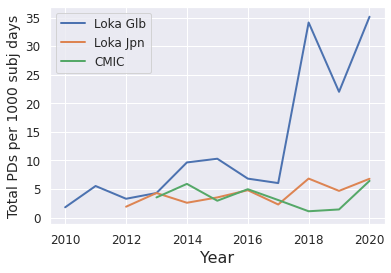

In [304]:
for col in tempaa.columns:
    plt.plot(tempaa[col], linewidth=2, label=col)

plt.xlabel('Year', fontsize=16)
plt.ylabel('Total PDs per 1000 subj days', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
# plt.set_cmap('Paired') # You can set the colormap to the graph
plt.show()

In [305]:
## Doing the same for 2nd metric - major pd by total pd

In [306]:
# Major PD/Total Japan Lokavant

In [307]:
df = add_start_date(lok_jp_met_fin_mtp)

In [308]:
df['start_of_work'] = pd.to_datetime(df['start_of_work'])

med5 = shift_index(df.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalmajpd_by_totpd']

In [309]:
med5.to_frame()

,totalmajpd_by_totpd
start_of_work,
2014-01-01,245.437616
2015-01-01,162.790698
2016-01-02,282.051282
2017-01-01,NaN
2018-01-01,111.111111
2019-01-01,144.000000
2020-01-02,43.859649


In [310]:
# Major pd by total pd CMIC

In [311]:
cmic_glb_met_fin_mtp['start_of_work'] = pd.to_datetime(cmic_glb_met_fin_mtp['start_of_work'])

In [312]:
med6 = shift_index(cmic_glb_met_fin_mtp.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )['totalmajpd_by_totpd']

In [313]:
med6.to_frame()

,totalmajpd_by_totpd
start_of_work,
2012-01-02,100.000000
2013-01-01,NaN
2014-01-01,204.428112
2015-01-01,279.069767
2016-01-02,240.000000
2017-01-01,152.925532
2018-01-01,76.767677
2019-01-01,NaN
2020-01-02,375.000000


In [314]:
tempb= pd.merge(med4,med5,on='start_of_work',how='outer')

In [315]:
tempb

,totalmajpd_by_totpd_x,totalmajpd_by_totpd_y
start_of_work,,
2014-01-01,136.634448,245.437616
2015-01-01,140.546875,162.790698
2016-01-02,129.627752,282.051282
2017-01-01,360.596542,NaN
2018-01-01,55.232504,111.111111
2019-01-01,73.443798,144.000000
2020-01-02,53.225229,43.859649


In [316]:
tempbb = pd.merge(med6,tempb,on='start_of_work',how='outer')

In [317]:
tempbb

,totalmajpd_by_totpd,totalmajpd_by_totpd_x,totalmajpd_by_totpd_y
start_of_work,,,
2012-01-02,100.000000,NaN,NaN
2013-01-01,NaN,NaN,NaN
2014-01-01,204.428112,136.634448,245.437616
2015-01-01,279.069767,140.546875,162.790698
2016-01-02,240.000000,129.627752,282.051282
2017-01-01,152.925532,360.596542,NaN
2018-01-01,76.767677,55.232504,111.111111
2019-01-01,NaN,73.443798,144.000000
2020-01-02,375.000000,53.225229,43.859649


In [318]:
tempbb = tempbb.rename(columns={"totalmajpd_by_totpd_x" : "Loka Glb", "totalmajpd_by_totpd_y" : "Loka Jpn", "totalmajpd_by_totpd" : "CMIC"})

## plotting line graph for 2nd metric - mtr

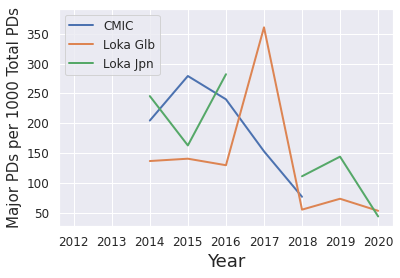

In [323]:
for col in tempbb.columns:
    plt.plot(tempbb[col], linewidth=2, label=col)

plt.xlabel('Year', fontsize=18)
plt.ylabel('Major PDs per 1000 Total PDs', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
#fig.set_figheight(10)
#fig.set_figwidth(15)
#plt.figure(figsize=(20,20))
# plt.set

In [324]:
## Functions for plotting graphs

In [325]:

def overall_boxplot(lok_global, lok_japan, cmic, kri, row_num, japan_on=True):
    l_g = lok_global[kri].dropna()
    l_j = lok_japan[kri].dropna()
    c   = cmic[kri].dropna()

    if japan_on:
        data = [l_g, l_j, c]
        fig, ax = plt.subplots()
        ax.boxplot(data, showfliers=False)
        ax.set_ylabel('Percentage')
        ax.set_title(kri)
        plt.xticks((1,2,3), ['Lokavant - Global', 'Lokavant - Japan', 'CMIC'])
        fig.tight_layout()
        fig.savefig(f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_overall_boxplot_w_japan.jpg')

    else:
        data = [l_g, c]
        fig, ax = plt.subplots()
        ax.boxplot(data, showfliers=False)
        ax.set_ylabel('Percentage')
        ax.set_title(kri)
        plt.xticks((1,2), ['Lokavant - Global', 'CMIC'])
        fig.tight_layout()
        fig.savefig(f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_overall_boxplot_wo_japan.jpg')



    return None


def multiple_comparisons_phases(pxl, pxl_japan, cmic, kri, row_num=None, japan_on=True):
    # attatch string for grouping later
    pxl['group'] = 'Lokavant Global'
    pxl_japan['group'] = 'Lokavant Japan'
    cmic['group'] = 'CMIC'

    cmic.rename(columns={'phase':'b_phase'}, inplace=True)

    if japan_on:
        # concatenate tables
        multi_df = pd.concat([pxl[[kri, 'b_phase', 'group']],
                            pxl_japan[[kri, 'b_phase','group']],
                            cmic[[kri,'b_phase','group']]])

        # only cutting by phase I, II, III, and IV
        multi_df = multi_df.loc[(multi_df['b_phase']=='I') | (multi_df['b_phase']=='II') | (multi_df['b_phase']=='III') | (multi_df['b_phase']=='IV')]
        multi_df = multi_df.sort_values(by='b_phase')

        # phase boxplot
        fig1, ax1 = plt.subplots()
        sns.boxplot(x='b_phase', y=kri, data=multi_df, hue='group', showfliers=False)
        plt.ylabel('Percentage')
        plt.title(f'kri across phases', fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 0.9))
        fpath = f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_grouped_boxplot_w_japan.jpg'
        fig1.tight_layout()
        fig1.savefig(fpath)

        # tukeys multiple comparisons
        multi_df['group_phase'] = multi_df['group'] + '_' + multi_df['b_phase']

        tukey = pairwise_tukeyhsd(endog=multi_df[kri].to_numpy(),
                                groups=multi_df['group_phase'].tolist(),
                                alpha=0.05)
        fig2, ax2 = plt.subplots()
        tukey.plot_simultaneous(ax=ax2);
        plt.xlabel(f'{kri} [%]');
        fig2.tight_layout()
        fpath = f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_tukeys_w_japan.jpg'
        print(tukey.summary())
        
        with open(f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_tukeys_w_japan.txt', 'w') as f:
            f.write(str(tukey.summary()))

    else:
        # concatenate tables
        multi_df = pd.concat([pxl[[kri, 'b_phase', 'group']],
                            cmic[[kri,'b_phase','group']]])

        # only cutting by phase I, II, III, and IV
        multi_df = multi_df.loc[(multi_df['b_phase']=='I') | (multi_df['b_phase']=='II') | (multi_df['b_phase']=='III') | (multi_df['b_phase']=='IV')]
        multi_df = multi_df.sort_values(by='b_phase')

        # phase boxplot
        fig1, ax1 = plt.subplots()
        sns.boxplot(x='b_phase', y=kri, data=multi_df, hue='group', showfliers=False)
        plt.ylabel('Percentage')
        plt.title(f'kri across phases', fontsize=16)
        plt.legend(bbox_to_anchor=(1.05, 0.9))
        fpath = f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_grouped_boxplot_wo_japan.jpg'
        fig1.tight_layout()
        fig1.savefig(fpath)

        # tukeys multiple comparisons
        multi_df['group_phase'] = multi_df['group'] + '_' + multi_df['b_phase']

        tukey = pairwise_tukeyhsd(endog=multi_df[kri].to_numpy(),
                                groups=multi_df['group_phase'].tolist(),
                                alpha=0.05)

        fig2, ax2 = plt.subplots()
        tukey.plot_simultaneous(ax=ax2);
        plt.xlabel(f'{kri} [%]');
        fig2.tight_layout()
        fpath = f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_tukeys_wo_japan.jpg'
        print(tukey.summary())

        with open(f'/home/ajay.keshava/Downloads/Pd_Analysis/{row_num}_tukeys_wo_japan.txt', 'w') as f:
            f.write(str(tukey.summary()))

    return None


def shift_index(gb):
    idx = gb.index - pd.Timedelta(364, 'days')
    gb = gb.set_index(idx)
    return gb


def time_linegraph(df, kri, sheet_name=None, writer=None):
    # calculate median, 75 and 25 %tile and shift the index to start at the beginning of the cal year
    df['start_of_work'] = pd.to_datetime(df['start_of_work'])

    med = shift_index( df.groupby(pd.Grouper(key='start_of_work', freq='Y')).median() )[kri]
    ub  = shift_index( df.groupby(pd.Grouper(key='start_of_work', freq='Y')).quantile(0.75) )[kri]
    lb  = shift_index( df.groupby(pd.Grouper(key='start_of_work', freq='Y')).quantile(0.25) )[kri]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.plot(med, label='Median')
    x_axis = [x - pd.Timedelta(364, 'days') for x in med.index.tolist()]


    ax.fill_between(med.index.tolist(), ub, lb, alpha=0.5, label='IQR')
    ax.set_xlim([datetime.datetime(2010, 1, 1), datetime.datetime(2021, 1, 1)])
    #ax.legend()
    ax.set_ylabel(kri, color='tab:blue')
    ax.set_xlabel('Start of Work Date')
    ax.set_title('{} Over Time'.format(kri), fontsize=16)

    fig.legend(bbox_to_anchor=(1.2, 0.9))

    ax.grid(False)
    #ax2.grid(False)

    desc = df.groupby(pd.Grouper(key='start_of_work', freq='Y')).describe()
    desc = desc.set_index(desc.index - pd.Timedelta(364, 'days'))

    if (sheet_name is not None) & (writer is not None):
        desc[kri].to_excel(writer, sheet_name=sheet_name)
        fig.tight_layout()
        file_name = f'/home/ajay.keshava/Downloads/Pd_Analysis/{sheet_name}.jpg'
        fig.savefig(file_name)
    
    return desc[kri]

## extracting to get pivoted data

In [326]:
'''
sql = \
    
    with 

    cte_start as (
    select b.event_name,
            a.cmdm_study_id::int as cmdm_study_id, 
            date(dim_date.calendar_dt) as actual_date

    -- grab study level data
    from raw_data.facts_study_accum_activity a

    -- merge on event codes
    inner join raw_data.dim_event_type b
    on a.cmdm_evt_typ_id = b.cmdm_evt_type_id

    -- get the calendar date conversion
    inner join raw_data.dim_date dim_date
    on a.cmdm_actual_date_id = dim_date.cmdm_date_id

    where b.cmdm_evt_type_id in (2, 132)
            and a.cmdm_actual_date_id > 1  
    ),

    cte_pivot as (
    select *
    from cte_start

    -- pivot to get one row per study
    pivot (min(actual_date) for event_name in ('Study Started', 'Study Closed at PAREXEL')) as p (cmdm_study_id, study_start, study_end)
    order by cmdm_study_id            
    ),

    cte_start_end as (
    select *, (study_end - study_start)/30 as time_elapsed
    from cte_pivot
    ),

    cte_fpi_lpi as (
    select  accum.cmdm_study_id::int as cmdm_study_id,
            date(min(dim_date.calendar_dt)) as FPI,
            date(max(dim_date.calendar_dt)) as LPI,
            (LPI - FPI)/30 as time_elapsed

    from raw_data.facts_subject_lifecycle_accum accum

    inner join raw_data.dim_date dim_date
    on accum.cmdm_randomized_date_id = dim_date.cmdm_date_id

    where cmdm_randomized_date_id > 1 
    group by cmdm_study_id
    ), 

    cte_lpo as (
    select  accum.cmdm_study_id::int as cmdm_study_id,
            date(max(dim_date.calendar_dt)) as LPO

    from raw_data.facts_subject_lifecycle_accum accum

    inner join raw_data.dim_date dim_date
    on accum.cmdm_completed_date_id = dim_date.cmdm_date_id

    where cmdm_completed_date_id > 1 
    group by cmdm_study_id
    )

    select  a.cmdm_study_id,
            a.study_start,
            a.study_end,
            b.fpi,
            b.lpi,
            c.lpo
            
    from cte_start_end a

    full outer join cte_fpi_lpi b
    on a.cmdm_study_id = b.cmdm_study_id

    full outer join cte_lpo c
    on a.cmdm_study_id = c.cmdm_study_id
    ; 
    

pxl_all_dates = pd.read_sql(sql, pxl)
'''

"\nsql =     \n    with \n\n    cte_start as (\n    select b.event_name,\n            a.cmdm_study_id::int as cmdm_study_id, \n            date(dim_date.calendar_dt) as actual_date\n\n    -- grab study level data\n    from raw_data.facts_study_accum_activity a\n\n    -- merge on event codes\n    inner join raw_data.dim_event_type b\n    on a.cmdm_evt_typ_id = b.cmdm_evt_type_id\n\n    -- get the calendar date conversion\n    inner join raw_data.dim_date dim_date\n    on a.cmdm_actual_date_id = dim_date.cmdm_date_id\n\n    where b.cmdm_evt_type_id in (2, 132)\n            and a.cmdm_actual_date_id > 1  \n    ),\n\n    cte_pivot as (\n    select *\n    from cte_start\n\n    -- pivot to get one row per study\n    pivot (min(actual_date) for event_name in ('Study Started', 'Study Closed at PAREXEL')) as p (cmdm_study_id, study_start, study_end)\n    order by cmdm_study_id            \n    ),\n\n    cte_start_end as (\n    select *, (study_end - study_start)/30 as time_elapsed\n    from cte

In [327]:
#pxl_all_dates.rename(columns={'study_start': 'start_of_work'}, inplace=True)
#pxl_all_dates.head()

In [328]:
pxl_all_dates.count()

cmdm_study_id    278
start_of_work    263
study_end        168
fpi               80
lpi               80
lpo               43
dtype: int64

In [329]:
def add_start_date(df):
    df['cmdm_study_id'] = df['cmdm_study_id'].astype(int)
    m = df.merge(pxl_all_dates, how='left')
    m = m.iloc[m['start_of_work'].dropna().index,:].reset_index(drop=True)

    return m

In [330]:
## Now lets segregate the data phase wise(ph1,ph2,ph3 and ph4),for both metrics(totalpd_by_sum_subdays and totalmajpd_by_totpd)
## and for all 3 sources(Lokavant global,lokavant japan and CMIC)

In [331]:
# 1.Lokavant global data with phases and metrics

In [332]:
lok_glb_met_fin_pds.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
0,32312,659782.0,5671,8.595263,III,Maintenance
1,46952,56344.0,1235,21.918927,II,Recruiting
2,3239,84717.0,256,3.021826,III,Completed
3,38352,84390.0,2867,33.973220,II,Recruiting
4,41332,3086.0,317,102.721970,II,Recruiting


### 1. Lokavant global, total pd/subject days metric and phase 1

In [333]:
##  lokavant global,metric -totalpd_by_sum_subdays and for phase1. -> 
##  lok_glb_met_fin_pds,totalpd_by_sum_subdays and phase1
lok_glb_pds_ph1 =  lok_glb_met_fin_pds[lok_glb_met_fin_pds['b_phase']== 'I']

In [334]:
lok_glb_pds_ph1.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
5,35792,2228.0,518,232.495512,I,Recruiting
24,38892,5689.0,1181,207.593602,I,Maintenance
27,38552,3032.0,3,0.989446,I,Completed
33,36472,9841.0,105,10.669647,I,Maintenance
48,42892,12840.0,37,2.881620,I,Recruiting


In [335]:
lok_glb_pds_ph1.count()

cmdm_study_id             7
SUM(SUBJECT_DAYS)         7
total_pd                  7
totalpd_by_sum_subdays    7
b_phase                   7
crs_current_status        7
dtype: int64

### 2. Lokavant global, total pd/subject days metric and phase 2

In [336]:
##  lokavant global,metric -totalpd_by_sum_subdays and for phase2. -> 
##  lok_glb_met_fin_pds,totalpd_by_sum_subdays and phase2
lok_glb_pds_ph2 =  lok_glb_met_fin_pds[lok_glb_met_fin_pds['b_phase']== 'II']

In [337]:
lok_glb_pds_ph2.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
1,46952,56344.0,1235,21.918927,II,Recruiting
3,38352,84390.0,2867,33.973220,II,Recruiting
4,41332,3086.0,317,102.721970,II,Recruiting
6,38612,264.0,6,22.727273,II,Closeout
7,3251,14004.0,237,16.923736,II,Closeout


In [338]:
lok_glb_pds_ph2.count()

cmdm_study_id             24
SUM(SUBJECT_DAYS)         24
total_pd                  24
totalpd_by_sum_subdays    24
b_phase                   24
crs_current_status        24
dtype: int64

## 3. Lokavant global, total pd/subject days metric and phase 3

In [339]:
##  lokavant global,metric -totalpd_by_sum_subdays and for phase 3. -> 
##  lok_glb_met_fin_pds,totalpd_by_sum_subdays and phase 3
lok_glb_pds_ph3 =  lok_glb_met_fin_pds[lok_glb_met_fin_pds['b_phase']== 'III']

In [340]:
lok_glb_pds_ph3.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
0,32312,659782.0,5671,8.595263,III,Maintenance
2,3239,84717.0,256,3.021826,III,Completed
8,29313,237310.0,1120,4.719565,III,Maintenance
10,39652,127056.0,556,4.376023,III,Recruiting
11,6272,8114.0,49,6.038945,III,Completed


In [341]:
lok_glb_pds_ph3.count()

cmdm_study_id             47
SUM(SUBJECT_DAYS)         47
total_pd                  47
totalpd_by_sum_subdays    47
b_phase                   47
crs_current_status        47
dtype: int64

### 4. Lokavant global, total pd/subject days metric and phase 4

In [342]:
##  lokavant global,metric -totalpd_by_sum_subdays and for phase 4. -> 
##  lok_glb_met_fin_pds,totalpd_by_sum_subdays and phase 4
lok_glb_pds_ph4 =  lok_glb_met_fin_pds[lok_glb_met_fin_pds['b_phase']== 'IV']

In [343]:
lok_glb_pds_ph4.head()

,cmdm_study_id,SUM(SUBJECT_DAYS),total_pd,totalpd_by_sum_subdays,b_phase,crs_current_status
12,34992,5862.0,65,11.088366,IV,Recruiting
20,31133,103399.0,853,8.249596,IV,Completed
21,5332,264092.0,1923,7.281553,IV,Closeout
32,5,2479692.0,12954,5.224036,IV,Completed
35,31152,105402.0,531,5.037855,IV,Completed


In [344]:
lok_glb_pds_ph4.count()

cmdm_study_id             7
SUM(SUBJECT_DAYS)         7
total_pd                  7
totalpd_by_sum_subdays    7
b_phase                   7
crs_current_status        7
dtype: int64

### 5. Lokavant global, Major pd/Total pd metric and phase 1

In [345]:
##  lokavant global,metric -lok_glb_met_fin_mtp and for phase 1 -> 
##  lok_glb_met_fin_mtp, totalmajpd_by_totpd and phase 1
lok_glb_mtp_ph1  =  lok_glb_met_fin_mtp[lok_glb_met_fin_mtp['b_phase']== 'I']

In [346]:
lok_glb_mtp_ph1.head(10)

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd,b_phase,crs_current_status
3,35792,116,518,223.938224,I,Recruiting
13,34172,22,769,28.608583,I,Recruiting
24,38892,26,1181,22.015241,I,Maintenance
25,40352,14,38,368.421053,I,Recruiting
32,34632,13,53,245.283019,I,Maintenance
41,41052,16,117,136.752137,I,Recruiting
42,42892,2,37,54.054054,I,Recruiting
59,34712,10,148,67.567568,I,Closeout


In [347]:
df.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd,b_phase,crs_current_status,start_of_work,study_end,fpi,lpi,lpo
0,2472,45,6,133.333333,III,Completed,2014-11-24,2017-12-29,2015-11-17,2019-01-31,None
1,27272,39,11,282.051282,III,Recruiting,2016-09-01,None,2017-11-20,2021-09-27,2022-02-21
2,31112,14,1,71.428571,II,Completed,2015-07-15,2017-12-05,None,None,2016-10-03
3,3239,3,2,666.666667,III,Completed,2015-06-15,2020-10-30,2016-01-18,2016-11-29,2020-01-06
4,33672,52,8,153.846154,II,Completed,2018-03-01,2021-08-31,2019-01-24,2019-07-16,2019-09-23


In [348]:
lok_glb_mtp_ph1.count()

cmdm_study_id          8
count_major_pd         8
total_pd               8
totalmajpd_by_totpd    8
b_phase                8
crs_current_status     8
dtype: int64

### 6. Lokavant global, Major pd/Total pd metric and phase 2

In [349]:
##  lokavant global,metric -lok_glb_met_fin_mtp and for phase 2. -> 
##  lok_glb_met_fin_mtp, totalmajpd_by_totpd and phase 2
lok_glb_mtp_ph2  =  lok_glb_met_fin_mtp[lok_glb_met_fin_mtp['b_phase']== 'II']

In [350]:
lok_glb_mtp_ph2.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd,b_phase,crs_current_status
0,41332,5,317,15.772871,II,Recruiting
4,46952,113,1235,91.497976,II,Recruiting
5,38352,115,2867,40.111615,II,Recruiting
6,40413,82,458,179.039301,II,Closeout
8,3251,71,237,299.578059,II,Closeout


In [351]:
lok_glb_mtp_ph2.count()

cmdm_study_id          25
count_major_pd         25
total_pd               25
totalmajpd_by_totpd    25
b_phase                25
crs_current_status     25
dtype: int64

### 7. Lokavant global, Major pd/Total pd metric and phase 3

In [352]:
##  lokavant global,metric -lok_glb_met_fin_mtp and for phase 3. -> 
##  lok_glb_met_fin_mtp, totalmajpd_by_totpd and phase 3
lok_glb_mtp_ph3  =  lok_glb_met_fin_mtp[lok_glb_met_fin_mtp['b_phase']== 'III']

In [353]:
lok_glb_mtp_ph3.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd,b_phase,crs_current_status
1,32312,60,5671,10.580145,III,Maintenance
2,3239,31,256,121.093750,III,Completed
9,4242,181,1016,178.149606,III,Maintenance
10,39652,2,556,3.597122,III,Recruiting
12,3252,417,2083,200.192031,III,Recruiting


In [354]:
lok_glb_mtp_ph3.count()

cmdm_study_id          34
count_major_pd         34
total_pd               34
totalmajpd_by_totpd    34
b_phase                34
crs_current_status     34
dtype: int64


### 8. Lokavant global, Major pd/Total pd metric and phase 4

In [355]:
##  lokavant global,metric -lok_glb_met_fin_mtp and for phase 4. -> 
##  lok_glb_met_fin_mtp, totalmajpd_by_totpd and phase 4
lok_glb_mtp_ph4 =  lok_glb_met_fin_mtp[lok_glb_met_fin_mtp['b_phase']== 'IV']

In [356]:
lok_glb_mtp_ph4.head()

,cmdm_study_id,count_major_pd,total_pd,totalmajpd_by_totpd,b_phase,crs_current_status
7,34992,5,65,76.923077,IV,Recruiting
20,5332,419,1923,217.888716,IV,Closeout
23,31133,411,853,481.828839,IV,Completed
33,31152,202,531,380.414313,IV,Completed
69,31132,286,768,372.395833,IV,Completed


In [357]:
lok_glb_mtp_ph4.count()

cmdm_study_id          5
count_major_pd         5
total_pd               5
totalmajpd_by_totpd    5
b_phase                5
crs_current_status     5
dtype: int64

### 9. Lokavant Japan, Major pd/Total pd metric and phase 1

In [358]:
##  lokavant Japan,metric -lok_jp_met_fin_pds  and for phase 1 -> 
##  lok_jp_met_fin_pds,  totalpd_by_sum_subdays and phase 1
lok_jpn_pds_ph1 =  lok_jp_met_fin_pds[lok_jp_met_fin_pds['b_phase']== 'I']

In [359]:
lok_jpn_pds_ph1.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays,b_phase,crs_current_status
24,38552,3,3032.0,0.989446,I,Completed


In [360]:
lok_jpn_pds_ph1.count()

cmdm_study_id             1
total_pd                  1
total_subdays             1
totalpd_by_sum_subdays    1
b_phase                   1
crs_current_status        1
dtype: int64

### 10. Lokavant Japan, Major pd/Total pd metric and phase 2

In [361]:
##  lokavant Japan,metric -lok_jp_met_fin_pds  and for phase 2 -> 
##  lok_jp_met_fin_pds,  totalpd_by_sum_subdays and phase 2
lok_jpn_pds_ph2 =  lok_jp_met_fin_pds[lok_jp_met_fin_pds['b_phase']== 'II']

In [362]:
lok_jpn_pds_ph2.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays,b_phase,crs_current_status
8,31112,14,3968.0,3.528226,II,Completed
15,33672,52,8727.0,5.958520,II,Completed
30,46952,114,16786.0,6.791374,II,Recruiting
31,4713,43,5499.0,7.819604,II,Completed


In [363]:
lok_jpn_pds_ph2.count()

cmdm_study_id             4
total_pd                  4
total_subdays             4
totalpd_by_sum_subdays    4
b_phase                   4
crs_current_status        4
dtype: int64

### 11. Lokavant Japan, totalpd_by_sum_subdays metric and phase 3

In [364]:
##  lokavant Japan,metric -lok_jp_met_fin_pds  and for phase 3 -> 
##  lok_jp_met_fin_pds,  totalpd_by_sum_subdays and phase 3
lok_jpn_pds_ph3 =  lok_jp_met_fin_pds[lok_jp_met_fin_pds['b_phase']== 'III']

In [365]:
lok_jpn_pds_ph3.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays,b_phase,crs_current_status
0,2472,45,65013.0,0.692169,III,Completed
1,25465,92,63465.0,1.449618,III,Recruiting
2,27272,39,8140.0,4.791155,III,Recruiting
3,28312,110,16170.0,6.802721,III,Maintenance
4,28372,76,40617.0,1.871138,III,Completed


In [366]:
lok_jpn_pds_ph3.count()

cmdm_study_id             28
total_pd                  28
total_subdays             28
totalpd_by_sum_subdays    28
b_phase                   28
crs_current_status        28
dtype: int64

### 12. Lokavant Japan, totalpd_by_sum_subdays metric and phase 4

In [367]:
##  lokavant Japan,metric -lok_jp_met_fin_pds  and for phase 4 -> 
##  lok_jp_met_fin_pds,  totalpd_by_sum_subdays and phase 4
lok_jpn_pds_ph4 =  lok_jp_met_fin_pds[lok_jp_met_fin_pds['b_phase']== 'IV']

In [368]:
lok_jpn_pds_ph4.head()

,cmdm_study_id,total_pd,total_subdays,totalpd_by_sum_subdays,b_phase,crs_current_status


In [369]:
## There is no data for phase 4

### 13. Lokavant Japan, totalmajpd_by_totpd metric and phase 1

In [370]:
##  lokavant Japan,metric -lok_jp_met_fin_mtp  and for phase 1 -> 
##  lok_jp_met_fin_mtp,  totalmajpd_by_totpd and phase 1
lok_jpn_mtp_ph1 =  lok_jp_met_fin_mtp[lok_jp_met_fin_mtp['b_phase']== 'I']

In [371]:
lok_jpn_mtp_ph1 .head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd,b_phase,crs_current_status


In [372]:
## There is no data for phase 1

### 14. Lokavant Japan, totalmajpd_by_totpd metric and phase 2

In [373]:
##  lokavant Japan,metric -lok_jp_met_fin_mtp  and for phase 2 -> 
##  lok_jp_met_fin_mtp,  totalmajpd_by_totpd and phase 2
lok_jpn_mtp_ph2 =  lok_jp_met_fin_mtp[lok_jp_met_fin_mtp['b_phase']== 'II']

In [374]:
lok_jpn_mtp_ph2.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd,b_phase,crs_current_status
2,31112,14,1,71.428571,II,Completed
6,33672,52,8,153.846154,II,Completed
17,46952,114,5,43.859649,II,Recruiting
18,4713,43,7,162.790698,II,Completed


In [375]:
lok_jpn_mtp_ph2.count()

cmdm_study_id          4
total_pd               4
total_majorpd          4
totalmajpd_by_totpd    4
b_phase                4
crs_current_status     4
dtype: int64

### 15. Lokavant Japan, totalmajpd_by_totpd metric and phase 3

In [376]:
##  lokavant Japan,metric -lok_jp_met_fin_mtp  and for phase 3 -> 
##  lok_jp_met_fin_mtp,  totalmajpd_by_totpd and phase 3
lok_jpn_mtp_ph3 =  lok_jp_met_fin_mtp[lok_jp_met_fin_mtp['b_phase']== 'III']

In [377]:
lok_jpn_mtp_ph3.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd,b_phase,crs_current_status
0,2472,45,6,133.333333,III,Completed
1,27272,39,11,282.051282,III,Recruiting
3,31854,15,1,66.666667,III,Recruiting
4,31872,67,12,179.104478,III,Maintenance
5,3239,3,2,666.666667,III,Completed


In [378]:
lok_jpn_mtp_ph3.count()

cmdm_study_id          15
total_pd               15
total_majorpd          15
totalmajpd_by_totpd    15
b_phase                15
crs_current_status     15
dtype: int64

### 16. Lokavant Japan, totalmajpd_by_totpd metric and phase 4

In [379]:
##  lokavant Japan,metric -lok_jp_met_fin_mtp  and for phase 4 -> 
##  lok_jp_met_fin_mtp,  totalmajpd_by_totpd and phase 4
lok_jpn_mtp_ph4 =  lok_jp_met_fin_mtp[lok_jp_met_fin_mtp['b_phase']== 'IV']

In [380]:
lok_jpn_mtp_ph4.head()

,cmdm_study_id,total_pd,total_majorpd,totalmajpd_by_totpd,b_phase,crs_current_status


In [381]:
## No data for phase 4

### 17. CMIC, totalpd_by_sum_subdays metric and phase 1

In [382]:
cmic_glb_met_fin_pds.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
0,AST0018,21435.0,163,7.604385,2014-05-01,0,III
1,BNP0026,11473.0,57,4.968186,2016-01-04,0,II
2,CGS0014,15997.0,94,5.876102,2017-11-01,1,III
3,FJY0011,22131.0,4,0.180742,2017-02-01,0,III
4,PIL0010,6420.0,1,0.155763,2018-12-03,0,II


In [383]:
## CMIC,metric - cmic_glb_met_fin_pds  and for phase 1 -> 
##  cmic_glb_met_fin_pds,  totalpd_by_sum_subdays and phase 1
cmic_glb_pds_ph1 =  cmic_glb_met_fin_pds[cmic_glb_met_fin_pds['phase']== 'I']

In [384]:
cmic_glb_pds_ph1.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
11,BNE0001,2076.0,10,4.816956,2020-09-01,0,I
15,DIS0019,270.0,25,92.592593,2016-10-01,0,I
18,BYP0018,1695.0,10,5.899705,2014-09-01,0,I
22,FUS0010,2249.0,53,23.566029,2016-07-01,0,I
25,BYP0024,218.0,65,298.165138,2015-11-01,0,I


In [385]:
cmic_glb_pds_ph1.count()

protocol_code             5
tot_sub_days              5
total_pd                  5
totalpd_by_sum_subdays    5
start_of_work             5
rbm                       5
phase                     5
dtype: int64

### 18. CMIC, totalpd_by_sum_subdays metric and phase 2

In [386]:
## CMIC,metric - cmic_glb_met_fin_pds  and for phase 2 -> 
##  cmic_glb_met_fin_pds,  totalpd_by_sum_subdays and phase 2
cmic_glb_pds_ph2 =  cmic_glb_met_fin_pds[cmic_glb_met_fin_pds['phase']== 'II']

In [387]:
cmic_glb_pds_ph2.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
1,BNP0026,11473.0,57,4.968186,2016-01-04,0,II
4,PIL0010,6420.0,1,0.155763,2018-12-03,0,II
8,KWK0021,10163.0,30,2.951884,2015-12-01,0,II
13,KOK0011,17997.0,23,1.277991,2017-10-01,0,II
20,SNG0021,26111.0,95,3.638313,2015-05-01,0,II


In [388]:
cmic_glb_pds_ph2.count()

protocol_code             9
tot_sub_days              9
total_pd                  9
totalpd_by_sum_subdays    9
start_of_work             9
rbm                       9
phase                     9
dtype: int64

### 19. CMIC, totalpd_by_sum_subdays metric and phase 3

In [389]:
## CMIC,metric - cmic_glb_met_fin_pds  and for phase 3 -> 
##  cmic_glb_met_fin_pds,  totalpd_by_sum_subdays and phase 3
cmic_glb_pds_ph3 =  cmic_glb_met_fin_pds[cmic_glb_met_fin_pds['phase']== 'III']

In [390]:
cmic_glb_pds_ph3.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
0,AST0018,21435.0,163,7.604385,2014-05-01,0,III
2,CGS0014,15997.0,94,5.876102,2017-11-01,1,III
3,FJY0011,22131.0,4,0.180742,2017-02-01,0,III
5,AST0019,282139.0,345,1.222802,2014-05-01,0,III
6,BNP0025,27987.0,4,0.142924,2016-01-01,0,III


In [391]:
cmic_glb_pds_ph3.count()

protocol_code             34
tot_sub_days              34
total_pd                  34
totalpd_by_sum_subdays    34
start_of_work             34
rbm                       34
phase                     34
dtype: int64

In [392]:
#writer = pd.ExcelWriter('~/Downloads/Cmic_Analysis/CMIC_ph3_pds.xlsx', engine='xlsxwriter')
#cmic_glb_pds_ph3.to_excel(writer, sheet_name='cmic_pds')
#writer.save()

### 20. CMIC, totalpd_by_sum_subdays metric and phase 4

In [393]:
## CMIC,metric - cmic_glb_met_fin_pds  and for phase 4 -> 
##  cmic_glb_met_fin_pds,  totalpd_by_sum_subdays and phase 4
cmic_glb_pds_ph4 =  cmic_glb_met_fin_pds[cmic_glb_met_fin_pds['phase']== 'IV']

In [394]:
cmic_glb_pds_ph4.head()

,protocol_code,tot_sub_days,total_pd,totalpd_by_sum_subdays,start_of_work,rbm,phase
26,DSC0015,48289.0,39,0.807637,2016-04-01,0,IV
29,AST0020,37631.0,63,1.674152,2016-10-01,0,IV


### 21. CMIC, totalmajpd_by_totpd metric and phase 1

In [395]:
cmic_glb_met_fin_mtp.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd,start_of_work,rbm,phase
0,FJY0011,1,4,250.000000,2017-02-01,0,III
1,ZLY0010,2,29,68.965517,2018-09-10,0,I
2,DIS0020,17,337,50.445104,2017-02-01,1,II
3,RTS0001,18,18,1000.000000,2020-05-19,0,I
4,CFE0018,1,49,20.408163,2018-07-01,0,III


In [396]:
## CMIC,metric - cmic_glb_met_fin_mtp   and for phase 1 -> 
##  cmic_glb_met_fin_mtp ,  totalmajpd_by_totpd and phase 1
cmic_glb_mtp_ph1 = cmic_glb_met_fin_mtp[cmic_glb_met_fin_mtp['phase']== 'I']

In [397]:
cmic_glb_mtp_ph1.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd,start_of_work,rbm,phase
1,ZLY0010,2,29,68.965517,2018-09-10,0,I
3,RTS0001,18,18,1000.000000,2020-05-19,0,I
25,DIS0019,6,25,240.000000,2016-10-01,0,I


### 22. CMIC, totalmajpd_by_totpd metric and phase 2

In [398]:
## CMIC,metric - cmic_glb_met_fin_mtp   and for phase 2 -> 
##  cmic_glb_met_fin_mtp ,  totalmajpd_by_totpd and phase 2
cmic_glb_mtp_ph2 = cmic_glb_met_fin_mtp[cmic_glb_met_fin_mtp['phase']== 'II']

In [399]:
cmic_glb_mtp_ph2.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd,start_of_work,rbm,phase
2,DIS0020,17,337,50.445104,2017-02-01,1,II
8,AST0016,6,60,100.000000,2012-02-01,0,II
11,UJF0011,8,64,125.000000,2017-06-01,0,II
19,BYP0059,6,16,375.000000,2020-05-07,1,II
23,PIL0010,1,1,1000.000000,2018-12-03,0,II


In [400]:
cmic_glb_mtp_ph2.count()

protocol_code          6
major_pd_count         6
total_pd               6
totalmajpd_by_totpd    6
start_of_work          6
rbm                    6
phase                  6
dtype: int64

### 23. CMIC, totalmajpd_by_totpd metric and phase 3

In [401]:
## CMIC,metric - cmic_glb_met_fin_mtp   and for phase 3 -> 
##  cmic_glb_met_fin_mtp ,  totalmajpd_by_totpd and phase 3
cmic_glb_mtp_ph3 = cmic_glb_met_fin_mtp[cmic_glb_met_fin_mtp['phase']== 'III']

In [402]:
cmic_glb_mtp_ph3.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd,start_of_work,rbm,phase
0,FJY0011,1,4,250.000000,2017-02-01,0,III
4,CFE0018,1,49,20.408163,2018-07-01,0,III
5,DSC0014,68,437,155.606407,2015-02-01,0,III
7,CFE0010,32,101,316.831683,2014-06-09,0,III
9,BNP0033,3,82,36.585366,2016-11-01,0,III


In [403]:
cmic_glb_mtp_ph3.count()

protocol_code          17
major_pd_count         17
total_pd               17
totalmajpd_by_totpd    17
start_of_work          17
rbm                    17
phase                  17
dtype: int64

### 24. CMIC, totalmajpd_by_totpd metric and phase 4

In [404]:
## CMIC,metric - cmic_glb_met_fin_mtp   and for phase 4 -> 
##  cmic_glb_met_fin_mtp ,  totalmajpd_by_totpd and phase 4
cmic_glb_mtp_ph4 = cmic_glb_met_fin_mtp[cmic_glb_met_fin_mtp['phase']== 'IV']

In [405]:
cmic_glb_mtp_ph4.head()

,protocol_code,major_pd_count,total_pd,totalmajpd_by_totpd,start_of_work,rbm,phase
6,DSC0015,9,39,230.769231,2016-04-01,0,IV


## Line plot individual phases

In [431]:
#line_pds_ph1

(0.0, 15.0)

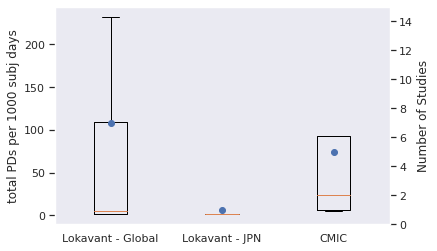

In [432]:
fig, ax = plt.subplots()
data = [lok_glb_pds_ph1.totalpd_by_sum_subdays.dropna(), lok_jpn_pds_ph1.totalpd_by_sum_subdays.dropna(),cmic_glb_pds_ph1.totalpd_by_sum_subdays.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('total PDs per 1000 subj days')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,15])

In [433]:
## line_pds_ph2

(0.0, 50.0)

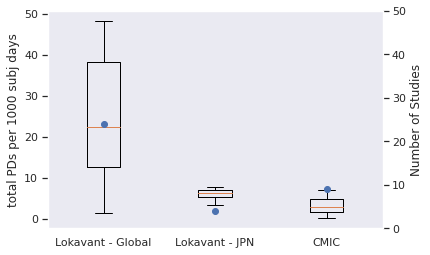

In [434]:
fig, ax = plt.subplots()
data = [lok_glb_pds_ph2.totalpd_by_sum_subdays.dropna(), lok_jpn_pds_ph2.totalpd_by_sum_subdays.dropna(),cmic_glb_pds_ph2.totalpd_by_sum_subdays.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('total PDs per 1000 subj days')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,50])

In [435]:
##line_pds_ph3

(0.0, 60.0)

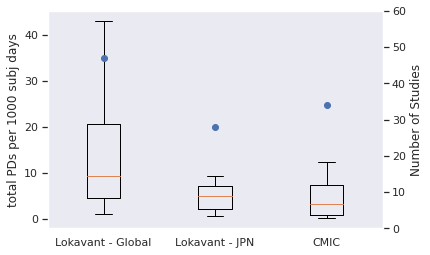

In [436]:
fig, ax = plt.subplots()
data = [lok_glb_pds_ph3.totalpd_by_sum_subdays.dropna(), lok_jpn_pds_ph3.totalpd_by_sum_subdays.dropna(),cmic_glb_pds_ph3.totalpd_by_sum_subdays.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('total PDs per 1000 subj days')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,60])

In [437]:
#line_pds_ph4

(0.0, 15.0)

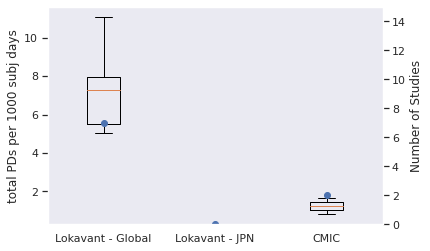

In [438]:
fig, ax = plt.subplots()
data = [lok_glb_pds_ph4.totalpd_by_sum_subdays.dropna(), lok_jpn_pds_ph4.totalpd_by_sum_subdays.dropna(),cmic_glb_pds_ph4.totalpd_by_sum_subdays.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('total PDs per 1000 subj days')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,15])

In [439]:
#line_mtp_ph1

(0.0, 50.0)

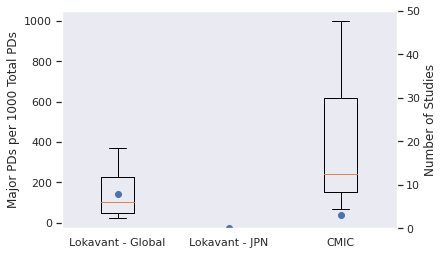

In [440]:
fig, ax = plt.subplots()
data = [lok_glb_mtp_ph1.totalmajpd_by_totpd.dropna(), lok_jpn_mtp_ph1.totalmajpd_by_totpd.dropna(),cmic_glb_mtp_ph1.totalmajpd_by_totpd.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('Major PDs per 1000 Total PDs')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,50])

In [441]:
#line_mtp_ph2

(0.0, 40.0)

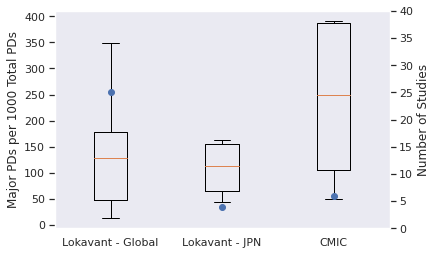

In [442]:
fig, ax = plt.subplots()
data = [lok_glb_mtp_ph2.totalmajpd_by_totpd.dropna(), lok_jpn_mtp_ph2.totalmajpd_by_totpd.dropna(),cmic_glb_mtp_ph2.totalmajpd_by_totpd.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('Major PDs per 1000 Total PDs')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,40])

In [443]:
## line_mtp_ph3

(0.0, 60.0)

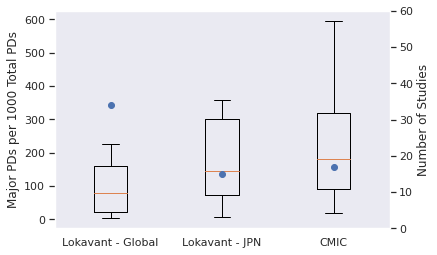

In [444]:
fig, ax = plt.subplots()
data = [lok_glb_mtp_ph3.totalmajpd_by_totpd.dropna(), lok_jpn_mtp_ph3.totalmajpd_by_totpd.dropna(),cmic_glb_mtp_ph3.totalmajpd_by_totpd.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('Major PDs per 1000 Total PDs')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,60])

In [445]:
#line mtp ph4

(0.0, 25.0)

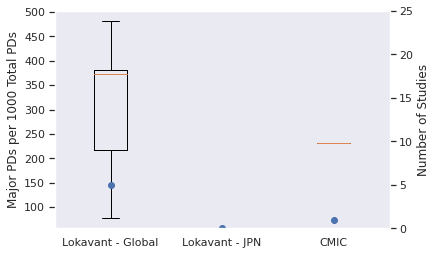

In [446]:
fig, ax = plt.subplots()
data = [lok_glb_mtp_ph4.totalmajpd_by_totpd.dropna(), lok_jpn_mtp_ph4.totalmajpd_by_totpd.dropna(),cmic_glb_mtp_ph4.totalmajpd_by_totpd.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('Major PDs per 1000 Total PDs')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,25])

In [447]:
## box plot for pds metric for lok glb, lok jpn and cmic(all phases)

(0.0, 100.0)

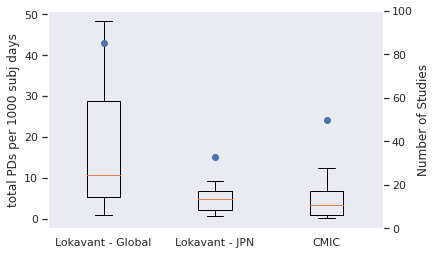

In [448]:
fig, ax = plt.subplots()
data = [lok_glb_met_fin_pds.totalpd_by_sum_subdays.dropna(), lok_jp_met_fin_pds.totalpd_by_sum_subdays.dropna(),cmic_glb_met_fin_pds.totalpd_by_sum_subdays.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('total PDs per 1000 subj days')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,100])

In [449]:
## box mtp for lok glb, lok jpn and cmic(including all phases)

(0.0, 100.0)

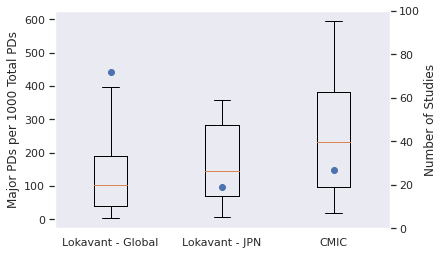

In [450]:
fig, ax = plt.subplots()
data = [lok_glb_met_fin_mtp.totalmajpd_by_totpd.dropna(), lok_jp_met_fin_mtp.totalmajpd_by_totpd.dropna(),cmic_glb_met_fin_mtp.totalmajpd_by_totpd.dropna() ]
ax.boxplot(data, showfliers=False) #showfliers = false will remove the outliers while plotting the boxplot.
plt.xticks((1,2,3), ('Lokavant - Global','Lokavant - JPN', 'CMIC'))
#ax.set_title(title, fontsize=16)
ax.grid(False)
ax.set_ylabel('Major PDs per 1000 Total PDs')
ax2 = ax.twinx()
data = [len(x) for x in data]
ax2.scatter((1,2,3), data)
ax2.set_ylabel('Number of Studies')
ax2.grid(False)
ax2.set_ylim([0,100])

In [ ]:
## Tukey plot for 1st metric - total pd by total sum of subject days

In [ ]:
multiple_comparisons_phases(lok_glb_met_fin_pds, lok_jp_met_fin_pds, cmic_glb_met_fin_pds, 'totalpd_by_sum_subdays', row_num=None,japan_on=True)

In [ ]:
## Tukey plot for 2nd metric - major pd by total pds

In [ ]:
multiple_comparisons_phases(lok_glb_met_fin_mtp,lok_jp_met_fin_mtp, cmic_glb_met_fin_mtp, 'totalmajpd_by_totpd', row_num=None,japan_on=True)

In [ ]:
## Writing all the data and graphs as output in excel

In [481]:

lkvt_gb_pd_by_sd_rate.to_excel(writer, sheet_name='lok_glb_psr')
lkvt_jp_pd_by_sd_rate.to_excel(writer, sheet_name='lok_jpn_psr')
#cmic_glb_pd_by_sd_rate.to_excel(writer, sheet_name='cmic_psr')
ph_psr_lvk_glb.to_excel(writer, sheet_name='lok_glb_psr_ph')
ph_psr_lvk_jpn.to_excel(writer, sheet_name='lok_jpn_psr_ph')
ph_psr_cmic_glb.to_excel(writer, sheet_name='cmic_psr_ph')
#aa.to_excel(writer, sheet_name='lok_glb_psr_line')
#cc.to_excel(writer, sheet_name='lok_jpn_psr_line') 
#ee.to_excel(writer, sheet_name='cmic_psr_line')
#a.to_excel(writer, sheet_name='lok_glb_psr_ph1')
#b.to_excel(writer, sheet_name='lok_glb_psr_ph2') 
#c.to_excel(writer, sheet_name='lok_glb_psr_ph3')
#d.to_excel(writer, sheet_name='lok_glb_psr_ph4')
#i.to_excel(writer, sheet_name='lok_jpn_psr_ph1')
#j.to_excel(writer, sheet_name='lok_jpn_psr_ph2') 
#k.to_excel(writer, sheet_name='lok_jpn_psr_ph3')
#l.to_excel(writer, sheet_name='lok_jpn_psr_ph4')
#q.to_excel(writer, sheet_name='cmic_psr_ph1')
#r.to_excel(writer, sheet_name='cmic_psr_ph2') 
#s.to_excel(writer, sheet_name='cmic_psr_ph3')
#t.to_excel(writer, sheet_name='cmic_psr_ph4')
lkvt_gb_mp_by_tp_rate.to_excel(writer, sheet_name='lok_glb_mtr')
lkvt_jp_mp_by_tp_rate.to_excel(writer, sheet_name='lok_jpn_mtr')
#cmic_glb_mp_by_tp_rate.to_excel(writer, sheet_name='cmic_mtr')
ph_mtr_lvk_glb.to_excel(writer, sheet_name='lok_glb_mtr_ph')
#ph_mtr_lvk_jpn.to_excel(writer, sheet_name='lok_jpn_mtr_ph')
ph_mtr_cmic_glb.to_excel(writer, sheet_name='cmic_mtr_ph')
#bb.to_excel(writer, sheet_name='lok_glb_mtr_line')
#dd.to_excel(writer, sheet_name='lok_jpn_mtr_line') 
#ff.to_excel(writer, sheet_name='cmic_mtr_line')
#e.to_excel(writer, sheet_name='lok_glb_mtr_ph1')
#f.to_excel(writer, sheet_name='lok_glb_mtr_ph2') 
#g.to_excel(writer, sheet_name='lok_glb_mtr_ph3')
#h.to_excel(writer, sheet_name='lok_glb_mtr_ph4')
#m.to_excel(writer, sheet_name='lok_jpn_mtr_ph1')
#n.to_excel(writer, sheet_name='lok_jpn_mtr_ph2') 
#o.to_excel(writer, sheet_name='lok_jpn_mtr_ph3')
#p.to_excel(writer, sheet_name='lok_jpn_mtr_ph4')
#u.to_excel(writer, sheet_name='cmic_mtr_ph1')
#v.to_excel(writer, sheet_name='cmic_mtr_ph2') 
#w.to_excel(writer, sheet_name='cmic_mtr_ph3')
#x.to_excel(writer, sheet_name='cmic_mtr_ph4')

writer.save()




/home/ajay.keshava/anaconda3/lib/python3.9/site-packages/xlsxwriter/workbook.py:338: UserWarning: Calling close() on already closed file.
  warn("Calling close() on already closed file.")
